# Search: Solving a Maze Using a Goal-based Agent

Student Name: Dimitri Lavin

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: DL

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [525]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [526]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

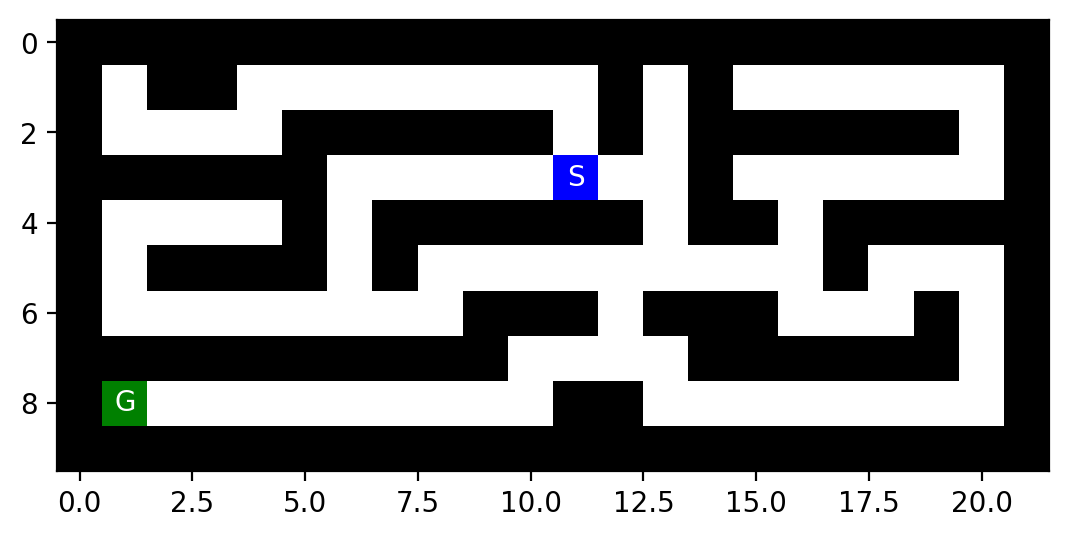

In [527]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [528]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [529]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /Users/dimitrilavin/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [530]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

# Code holding all mazes

['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' ' ' 'X']


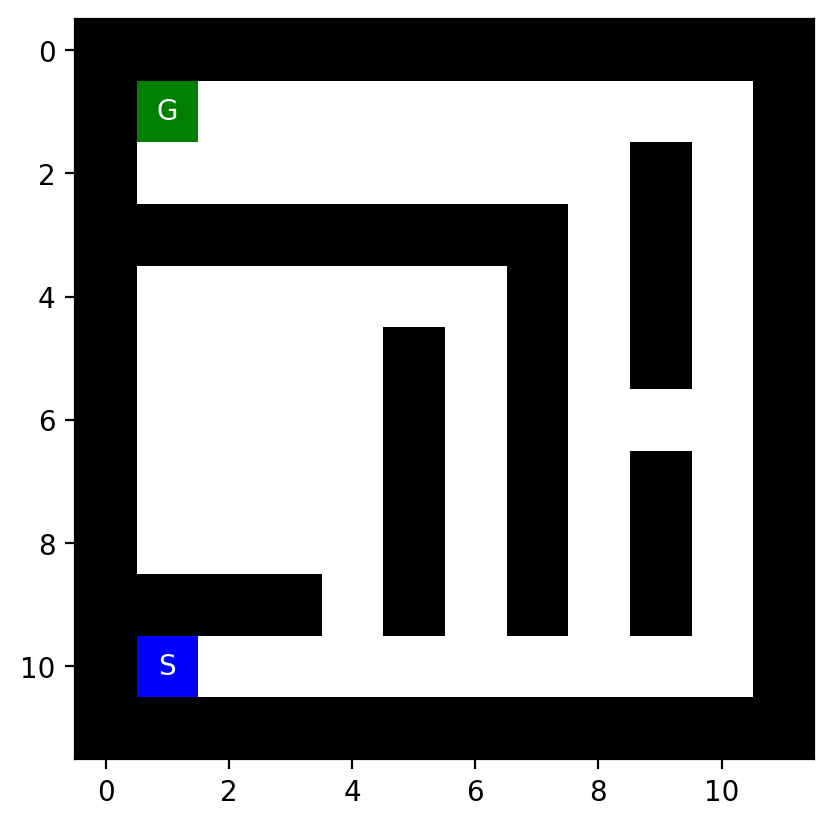

['X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' 'S' ' ' ' ' 'X' ' ' ' ' ' '
 ' ' ' ' ' ' 'X']


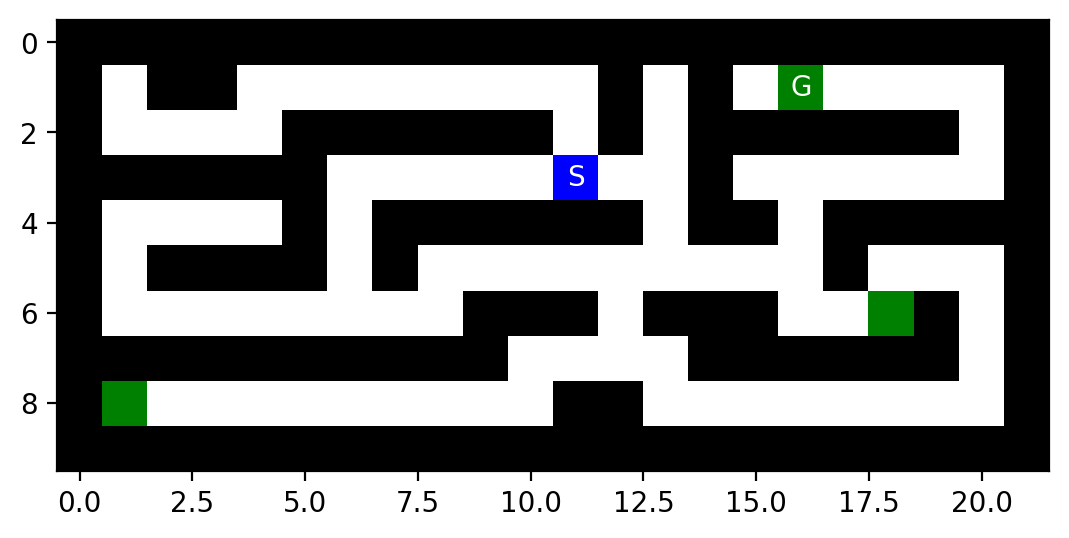

In [531]:
mazes = {
    "small": "small_maze.txt",
    "medium": "medium_maze.txt",
    "large": "large_maze.txt",
    "open": "open_maze.txt",
    "empty": "empty_maze.txt",
    "empty2": "empty_2_maze.txt",
    "wall": "wall_maze.txt",
    "loops": "loops_maze.txt"
}

advanced_mazes = {
    "small2": "small_maze2.txt",
    "medium2": "medium_maze2.txt",
    "large2": "large_maze2.txt"
}

global maze

#Function used to create the maze
def load_maze(name):
    maze_read = open(mazes[name], "r").read()
    return(mh.parse_maze(maze_read))

#Testing load_maze function
maze = load_maze("loops")
print(maze[3,])
mh.show_maze(maze)

#Function used to create the advanced maze
def load_advanced_maze(name):
    maze_read = open(advanced_mazes[name], "r").read()
    return(mh.parse_maze(maze_read))

#Testing load_maze function
maze = load_advanced_maze("small2")
print(maze[3,])
mh.show_maze(maze)

# Heuristics

In [532]:
import numpy as np
def g(n):
    return(len(n.get_path_from_root())-1)

def manhattan_dis(start, end):
    return(np.sum(np.abs(np.subtract(start,end))))

# Extra Functions

In [533]:
#Finds all the possible the positions the agent can go into by locating any X's
#in neighboring squares
def possible_positions(maze, pos, action = "random"):
    #Finding the adjacent squares of the current position
    neighbors = np.add(pos, [[-1,0], [0,1], [1,0], [0,-1]])[::-1]

    #If action isn't west, randomize action
    if(action != "W"):
        np.random.shuffle(neighbors)

    #List of squares to move into
    potential_actions = [ available_pos.tolist() for available_pos in neighbors if mh.look(maze, available_pos) != "X" ]

    return potential_actions


#Finds the position with the least number of steps
def least_steps(steps):
    return(np.random.choice(np.where(steps == np.amin(steps))[0]))


#Additional function that works with show_maze to visualize the final path
#and the test paths the search made for the agent.
def show_path(maze, path, reached = []):
    maze_copy = np.copy(maze)

    #Test code to see positions of the solution path of the search method
    #for node in path:
    #   print(node.pos)
    
    #Labels squares of the solution path as P
    for node in path:
        node_position = node.pos
        if(maze_copy[node_position[0], node_position[1]] == " "):
            maze_copy[node_position[0], node_position[1]] = "P"
           
    #Labels squares of other test paths taken as .
    for node_position in reached:
        if (maze_copy[node_position[0], node_position[1]] == " "):
            maze_copy[node_position[0], node_position[1]] = "."
            
    mh.show_maze(maze_copy)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

# Your answer goes here
Initial State: The initial state is the starting position for an agent in a maze. The initial state is marked by an S in a blue square using the AI Maze Visualizer.

Actions: The actions the agent can take are up, down, left, and right. The agent is free to take any of these actions as long as it is not being obstructed by a wall or it is not coming across a previously visited square. In the instance it comes across a wall or visited square, it will choose an action that will not take it into the wall or visited square. 

Transition Model: The transition model reflects the successive states from the actions taken by the agent. These states are the outcomes of the actions taken by the agent. With each successive state, the agent will make its way towards its goal in the maze. 

Goal State: The goal state is the position in the maze that the agent eventually wants to end up in. The goal state is marked by a G in a green square using the AI Maze Visualizer. 

Path Cost: The path cost is the number of steps it takes to get from the initial state to the goal state. Each step that is taken by the agent has a cost of 1. The path cost is marked by a red line that runs from the initial state to the goal state in the maze using the AI Maze Visualizer.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

# Your answer goes here
A rough estimate for the problem size would be $b^d$ or $b^m$. I use this as a rough estimate considering that the state space size is going to affect the branching factor of each node, as well as the maximum depth of the maze and the potential depth of the optimal solution. One has to traverse through at most $n*n$ squares where we encounter a space complexity of nodes that typically is around $O(b^d)$ or $O(b^m)$.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.


Strategy: BFS

Maze: small
Path Cost: 19
Squares Explored: 93
Frontier Maximum: 9
Depth Maximum: 19


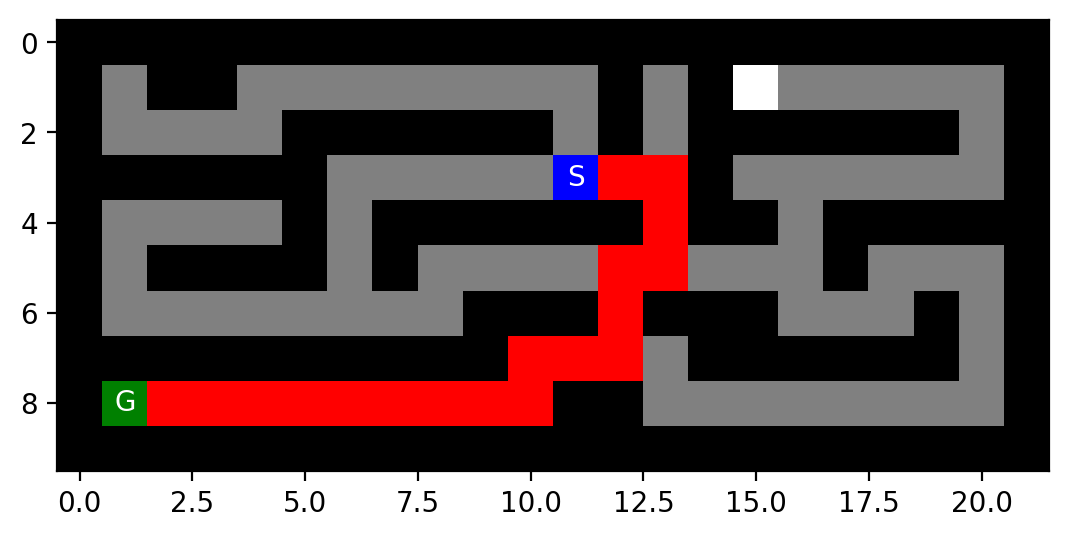

Maze: medium
Path Cost: 68
Squares Explored: 272
Frontier Maximum: 8
Depth Maximum: 69


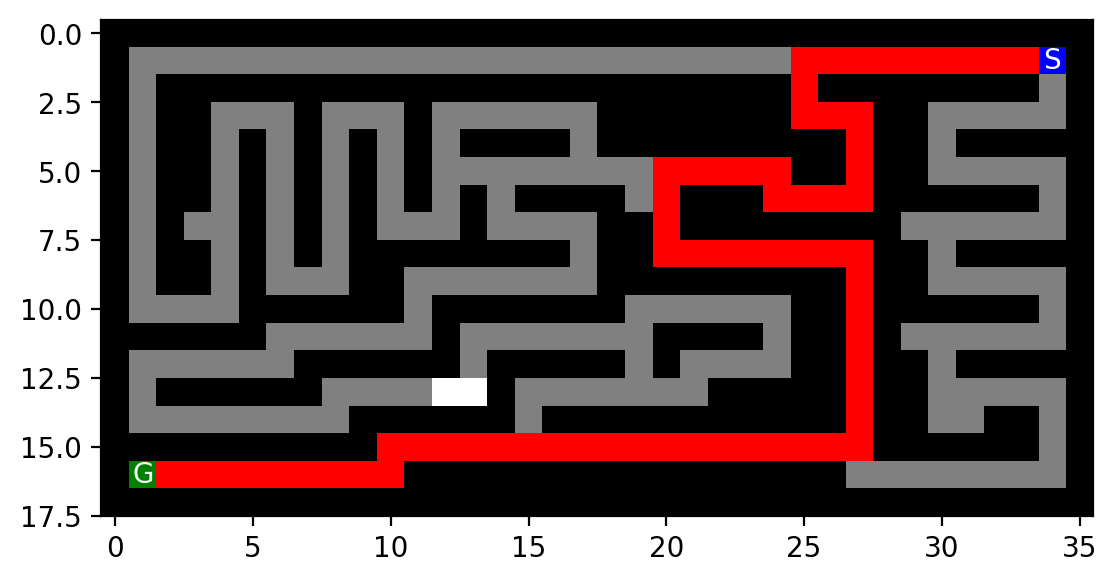

Maze: large
Path Cost: 210
Squares Explored: 624
Frontier Maximum: 8
Depth Maximum: 211


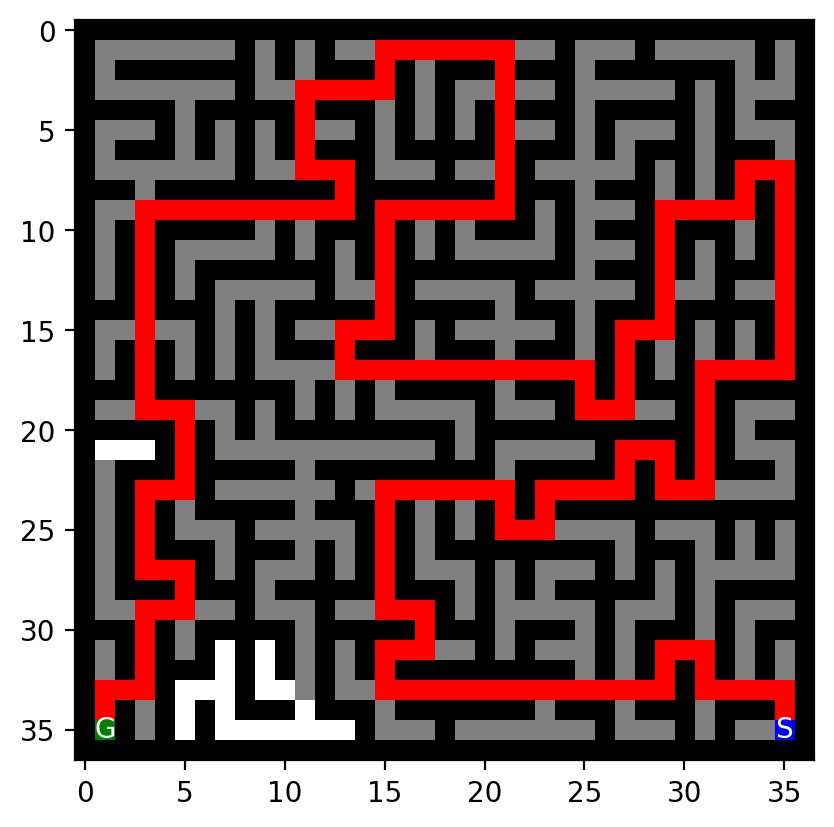

Maze: open
Path Cost: 54
Squares Explored: 684
Frontier Maximum: 25
Depth Maximum: 54


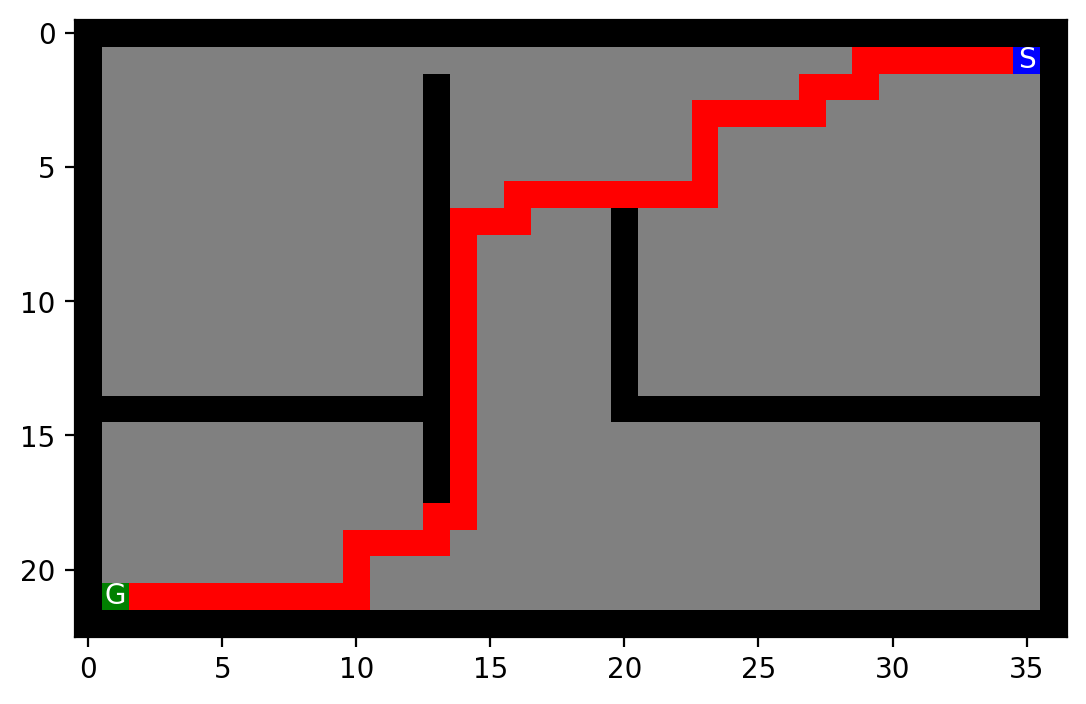

Maze: empty
Path Cost: 14
Squares Explored: 98
Frontier Maximum: 12
Depth Maximum: 15


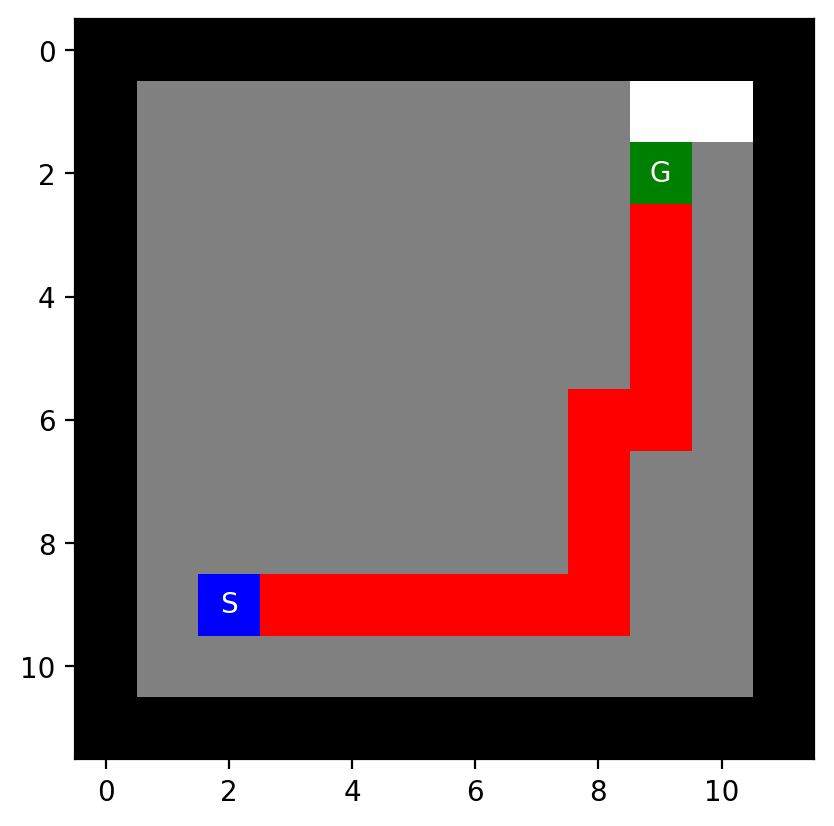

Maze: empty2
Path Cost: 14
Squares Explored: 98
Frontier Maximum: 12
Depth Maximum: 15


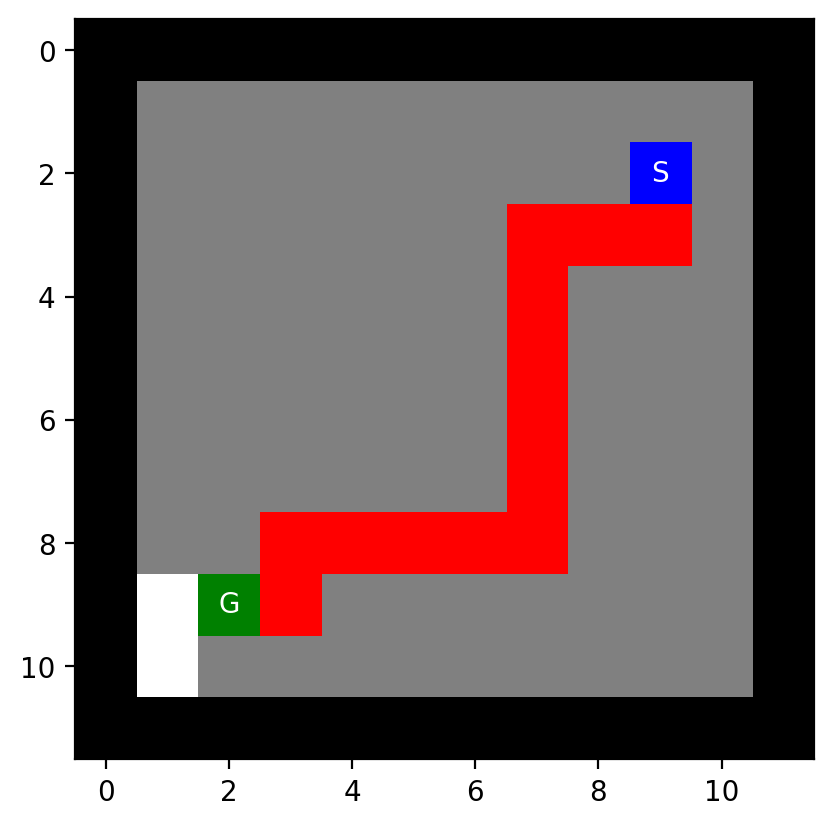

Maze: wall
Path Cost: 14
Squares Explored: 91
Frontier Maximum: 9
Depth Maximum: 15


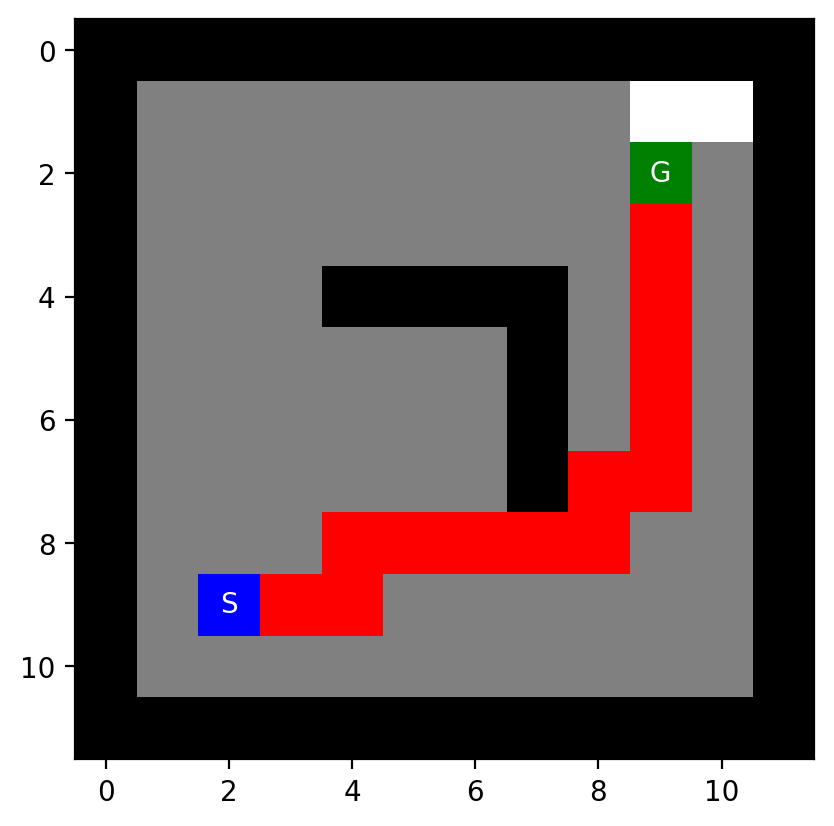

Maze: loops
Path Cost: 23
Squares Explored: 72
Frontier Maximum: 8
Depth Maximum: 23


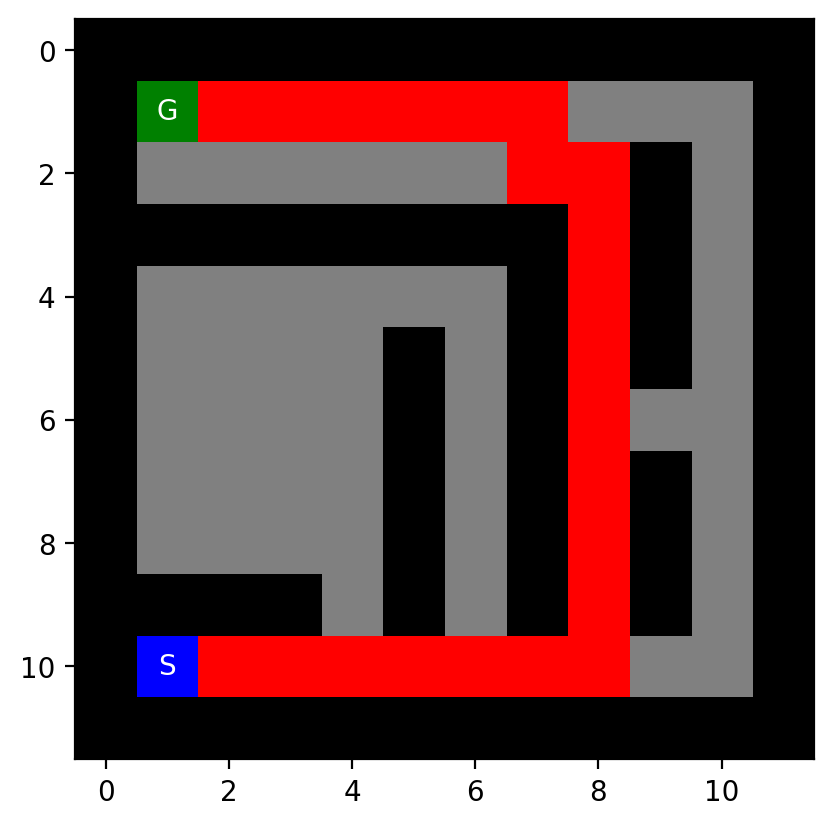


Strategy: DFS

Maze: small
Path Cost: 29
Squares Explored: 48
Frontier Maximum: 5
Depth Maximum: 29


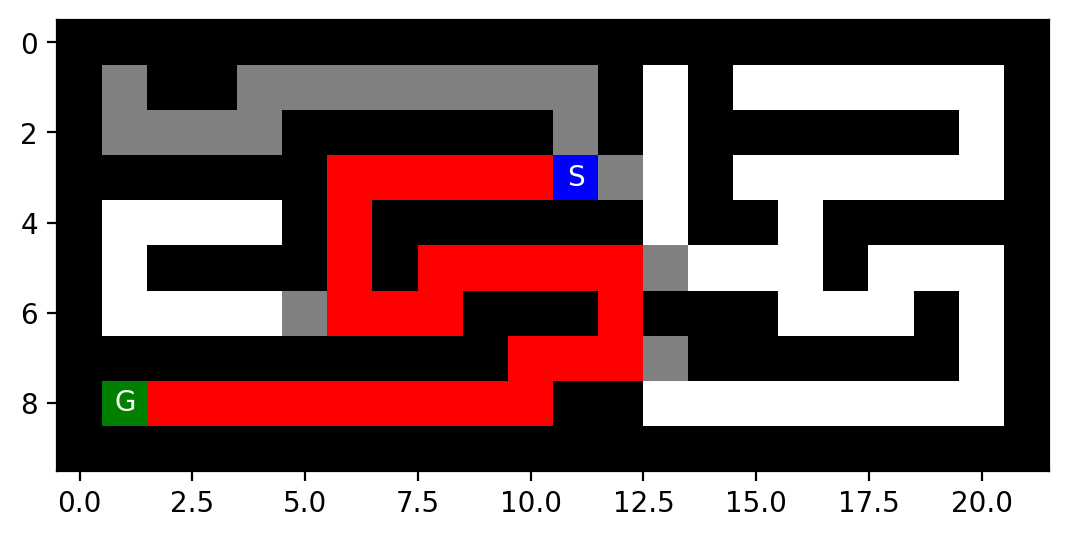

Maze: medium
Path Cost: 222
Squares Explored: 268
Frontier Maximum: 10
Depth Maximum: 222


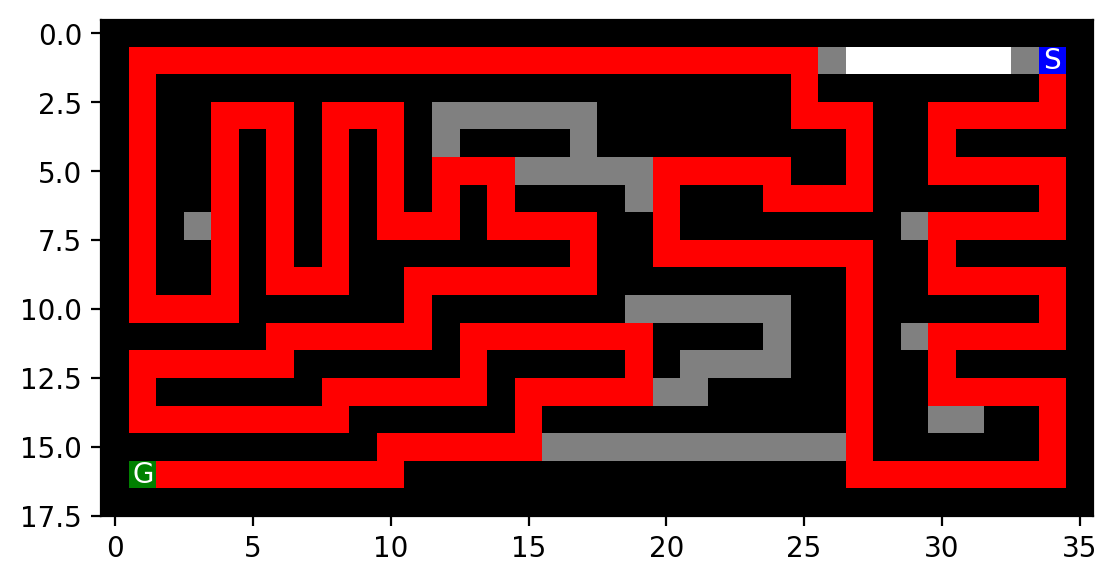

Maze: large
Path Cost: 210
Squares Explored: 495
Frontier Maximum: 33
Depth Maximum: 222


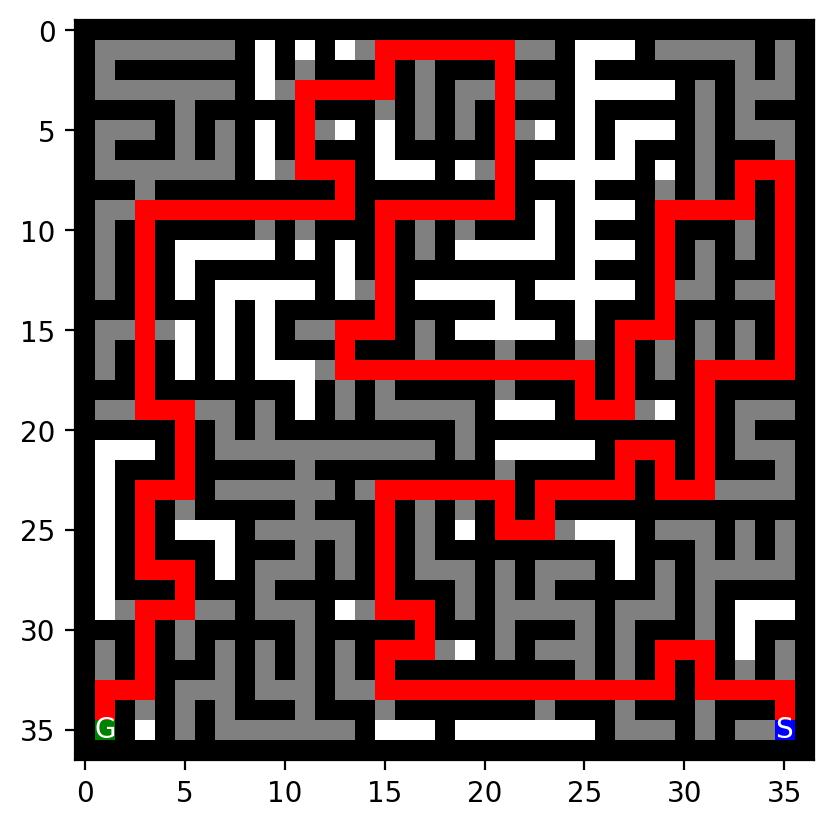

Maze: open
Path Cost: 118
Squares Explored: 507
Frontier Maximum: 145
Depth Maximum: 157


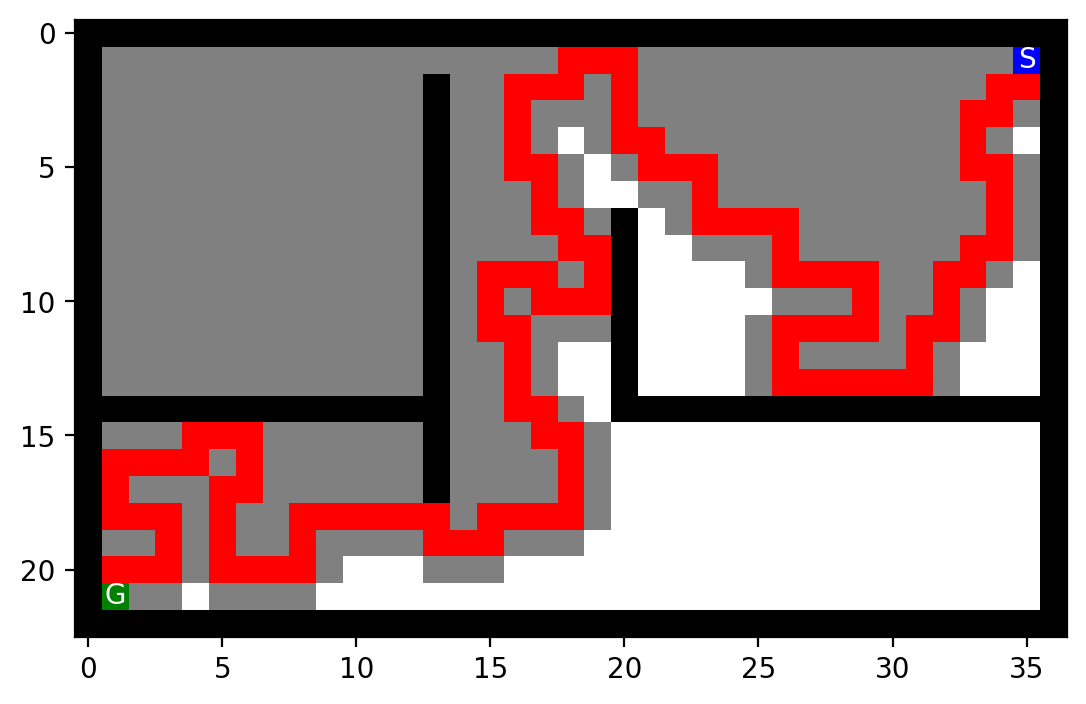

Maze: empty
Path Cost: 18
Squares Explored: 98
Frontier Maximum: 46
Depth Maximum: 47


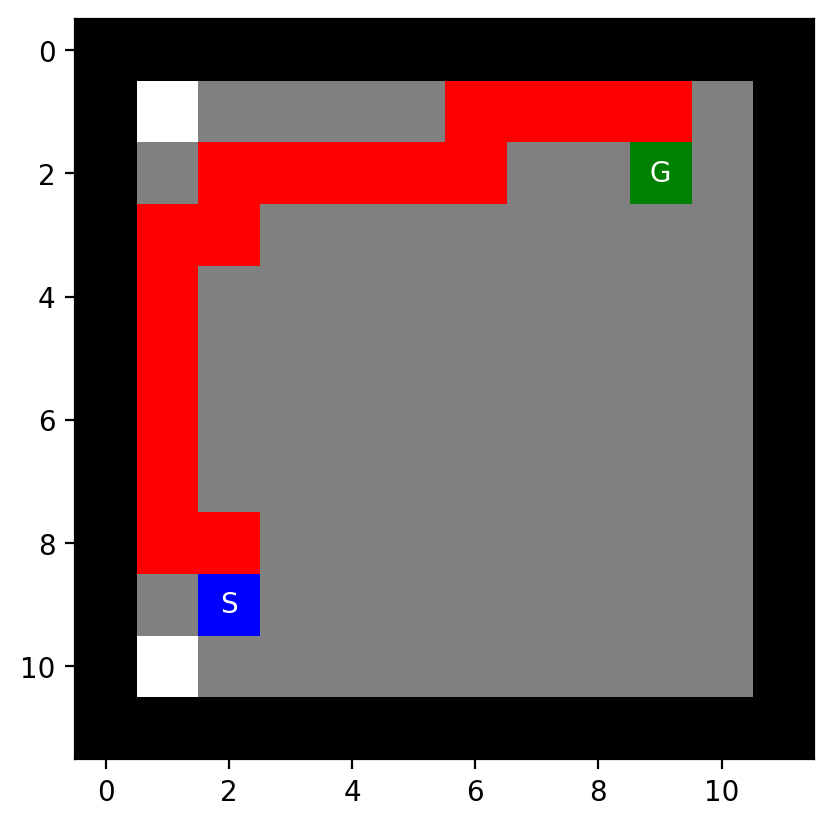

Maze: empty2
Path Cost: 30
Squares Explored: 94
Frontier Maximum: 39
Depth Maximum: 39


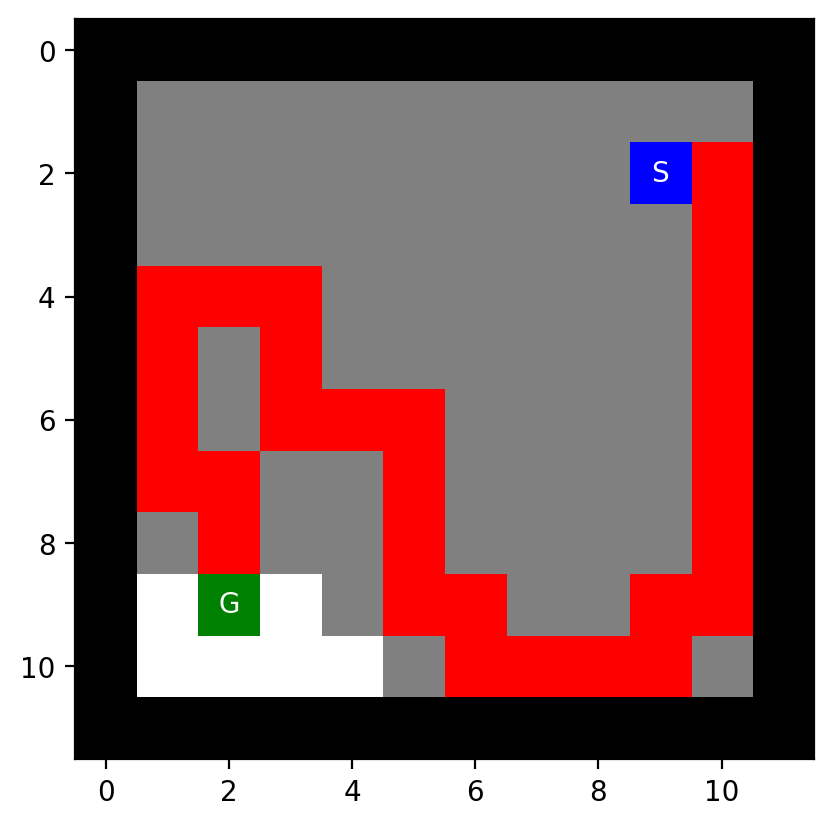

Maze: wall
Path Cost: 36
Squares Explored: 69
Frontier Maximum: 32
Depth Maximum: 36


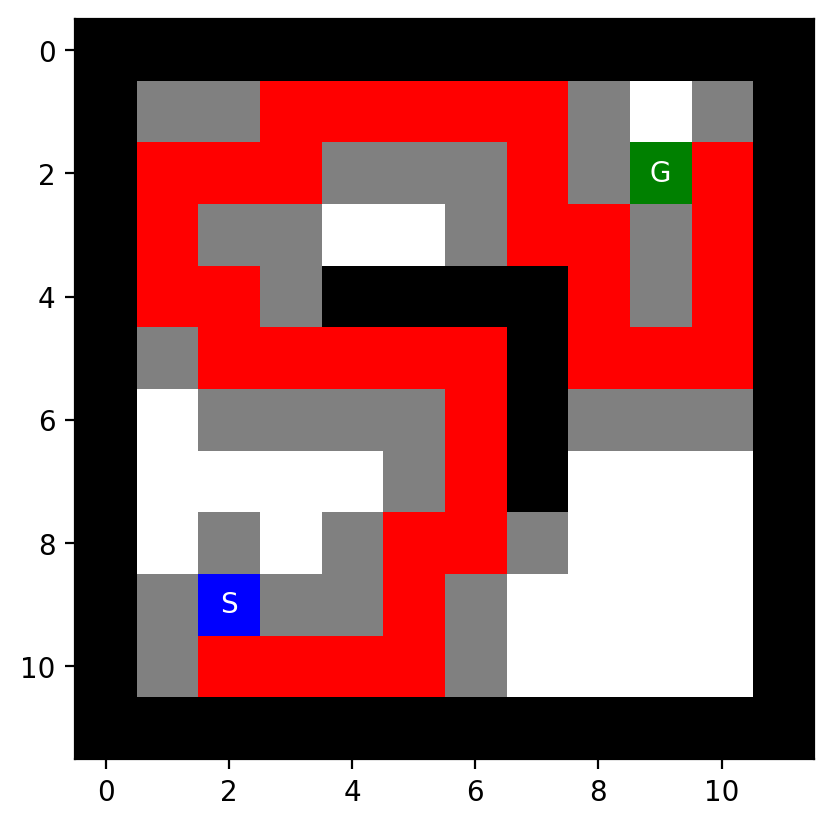

Maze: loops
Path Cost: 45
Squares Explored: 66
Frontier Maximum: 18
Depth Maximum: 45


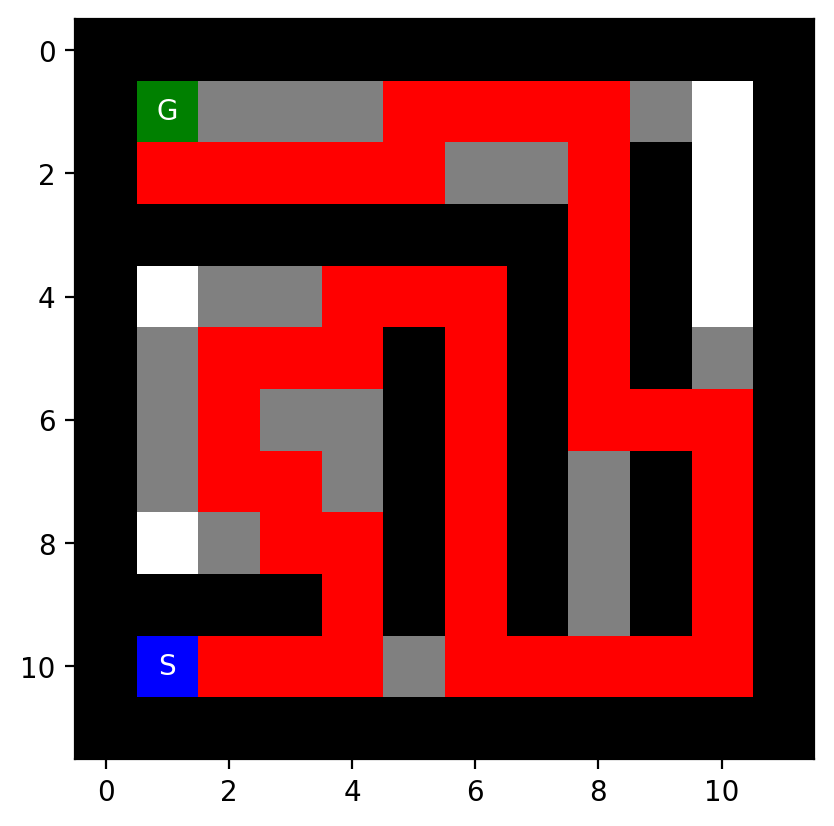

In [534]:
# Your code goes here
def task2_search(maze, search_method = "BFS"):

    #Find the initial state position and the goal state position
    start_pos = mh.find_pos(maze, "S")
    end_pos = mh.find_pos(maze, "G")
        
    #Initial state position becomes root node
    root = Node(pos=start_pos, parent=None, action=None, cost=0)

    #Creating the frontier for the search
    frontier = []
    frontier.append(root)

    #Creating list of nodes that have been visited
    reached = dict()
    reached[tuple(root.pos)] = root

    #Keeping track of the maximum frontier and depth
    frontier_maximum = 0
    depth_maximum = 0

    #Set the current node as the root node
    node = root
    
    #Keep searching until the goal state is reached or if nothing remains in the frontier
    while not (len(frontier) < 1):

        #Continue to update frontier maximum if necessary
        if(len(frontier) > frontier_maximum):
            frontier_maximum = len(frontier)

        #Using search method to move forward on the frontier
        if(search_method == "BFS"):
            node = frontier.pop(0)

        elif(search_method == "DFS"):
            node = frontier.pop(-1)

        else:
            print("Strategy does not exist.")
            return(None)
        
        #Check to see if the goal state has been reached
        if(mh.look(maze, node.pos) == "G"):
            return({
                "path": node.get_path_from_root(),
                "reached": reached.keys(),
                "frontier-maximum": frontier_maximum,
                "depth-maximum": depth_maximum
            })
        
        #Continue expanding from current node if not at goal state
        else:
            #Check what actions can be performed
            for position in possible_positions(maze, node.pos):
                #If an available and ideal action takes you to a visited node, do not add to frontier to prevent looping in search
                if(search_method in ["DFS"]):
                    if(tuple(position) in reached.keys()):
                        if(g(reached[tuple(position)]) <= g(node) + 1):
                            continue

                elif(tuple(position) in reached.keys()):
                    continue

                #If the successive position is not yet on the frontier or is a better node for the frontier, add it to frontier
                n = Node(pos=position, parent=node, action=None, cost=1)

                if(g(n) > depth_maximum):
                    depth_maximum = g(n)
                frontier.append(n)
                reached[tuple(position)] = n

    return(None)



def test_maze2(methods):
    print()
    for method in methods:
        print(f"Strategy: {method}")
        print()
        for search_maze in mazes.keys():
            maze = load_maze(search_maze)
            results = task2_search(maze, search_method=method)
            print("Maze: {}".format(search_maze))
            print("Path Cost: {}".format(len(results["path"])-1))
            print("Squares Explored: {}".format(len(results["reached"])))
            print("Frontier Maximum: {}".format(results["frontier-maximum"]))
            print("Depth Maximum: {}".format(results["depth-maximum"]))
            show_path(maze, results["path"], results["reached"])
        print()


search_methods = ["BFS", "DFS"]
test_maze2(search_methods)

How does BFS and DFS deal with loops (cycles)?

# Discussion
BFS deals with loops by keeping track of the vertices that it has already visited. When BFS comes across a visited vertex, it will not explore
it. Therefore, a cycle will never be started. DFS deals with loops by keeping track of the vertices it has visited as well as if it is currently 
exploring those vertices or if they were already explored through a recursion stack. When DFS comes across a vertex that is currently being explored on
the recursion stack, it becomes aware of a cycle.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

# Discussion
BFS: BFS is complete. In the code above, BFS succeeds by examining all nodes level by level, expanding on all nodes on each of those levels before going one level deeper. BFS is also optimal because it always returns the same cost to solve a given problem. Even though it may have to search through the entire maze, it will always find the best solution. For BFS, the time complexity is $O(b^d)$ where $b$ is the branching factor and $d$ is the depth of the optimal solution in the tree. The time complexity is $O(b^d)$ because per node, for each level we get another $b$ branches per node. At level one we get $b^1$, at level two we get $b^2$, at level three we get $b^3$, all the way up to level $d$ where we eventually get $b^d$. The same applies for the space complexity of BFS. Because we in the worst case we examine all nodes of a tree (or maze in this case), we examine all nodes from each level. As a result, we end up getting $O(b^d)$ space complexity.

DFS: DFS is complete. In the code above, DFS succeeds by going as deep as it can go on a given path, attempting each possible path until it reaches the goal state. DFS is not optimal because it will return the first path that reaches the goal state. Even if there are other paths that would have lower costs, it would fail to look at these paths simply because it returns the first path it iterates through that reaches the goal state. For DFS, the time complexity is $O(b^m)$ where $b$ is the branching factor and $m$ is the maximum depth of the tree. The time complexity is $O(b^m)$ because in the worst case, DFS has to examine each path it takes until it gets to the path that runs deepest through the tree. With each node potentially branching, we potentially have to examine one level deeper with each node we visit. At level one we get $b^1$, at level two we get $b^2$, at level three we get $b^3$, all the way up to level $m$ where we eventually get $b^m$. The space complexity of DFS would be $O(bm)$. This is because only one path is stored at a time, storing $b$ unexpanded nodes going $m$ nodes deep into the tree.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 


Strategy: GBFS

Maze: small
Path Cost: 29
Squares Explored: 44
Frontier Maximum: 5
Depth Maximum: 29


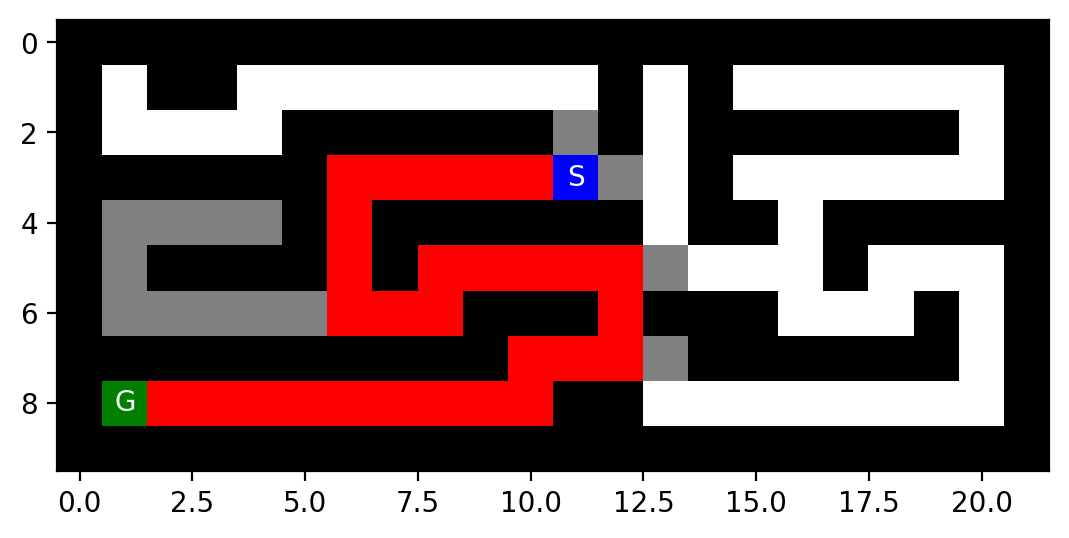

Maze: medium
Path Cost: 152
Squares Explored: 165
Frontier Maximum: 8
Depth Maximum: 152


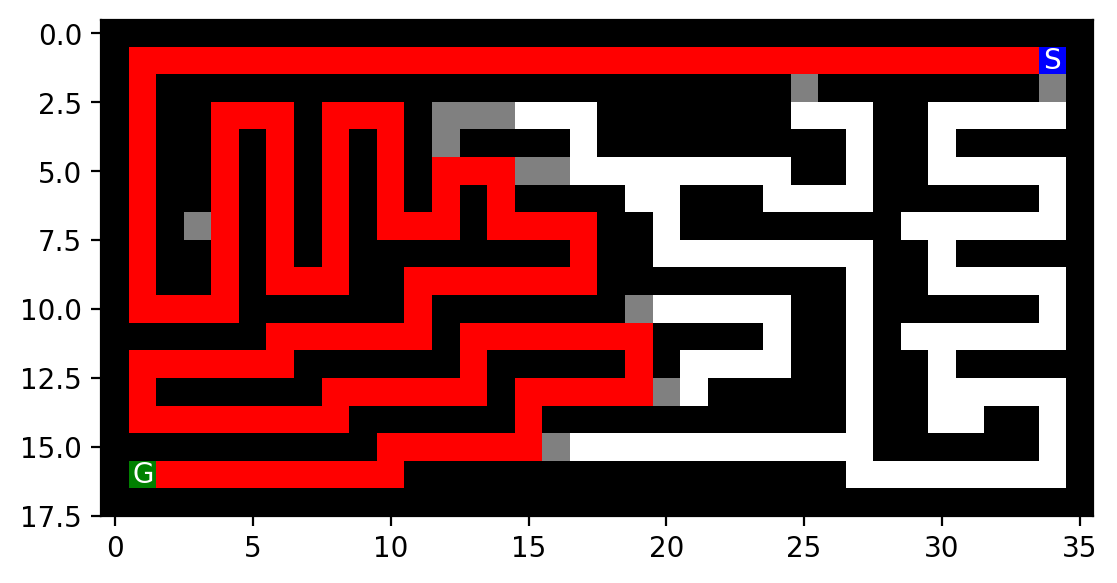

Maze: large
Path Cost: 210
Squares Explored: 489
Frontier Maximum: 23
Depth Maximum: 210


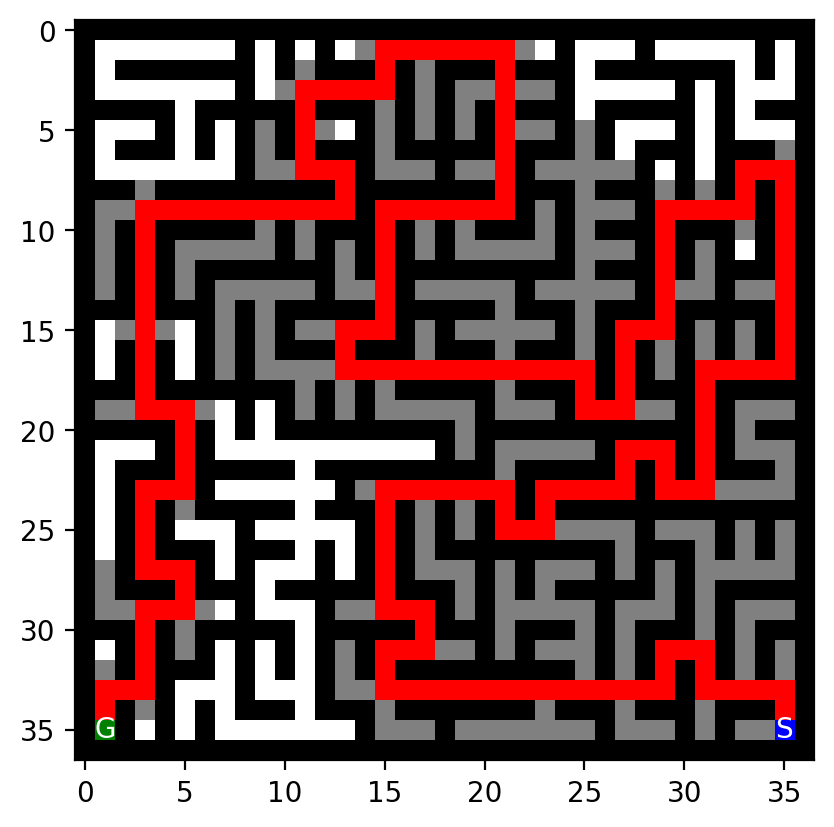

Maze: open
Path Cost: 68
Squares Explored: 156
Frontier Maximum: 77
Depth Maximum: 68


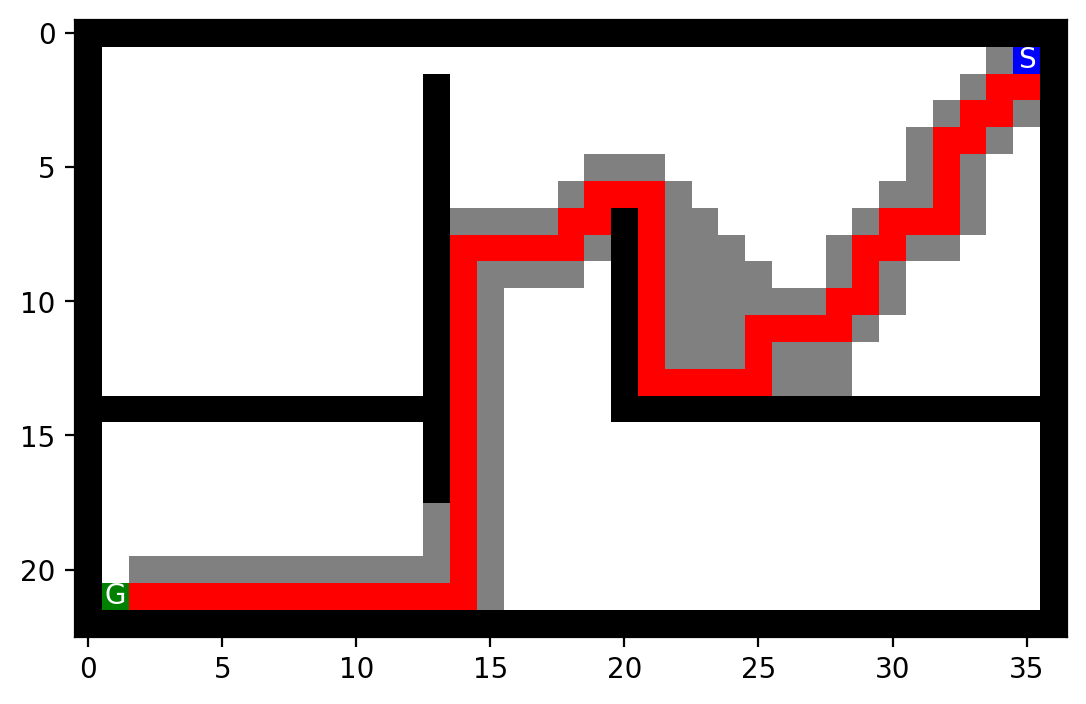

Maze: empty
Path Cost: 14
Squares Explored: 38
Frontier Maximum: 24
Depth Maximum: 14


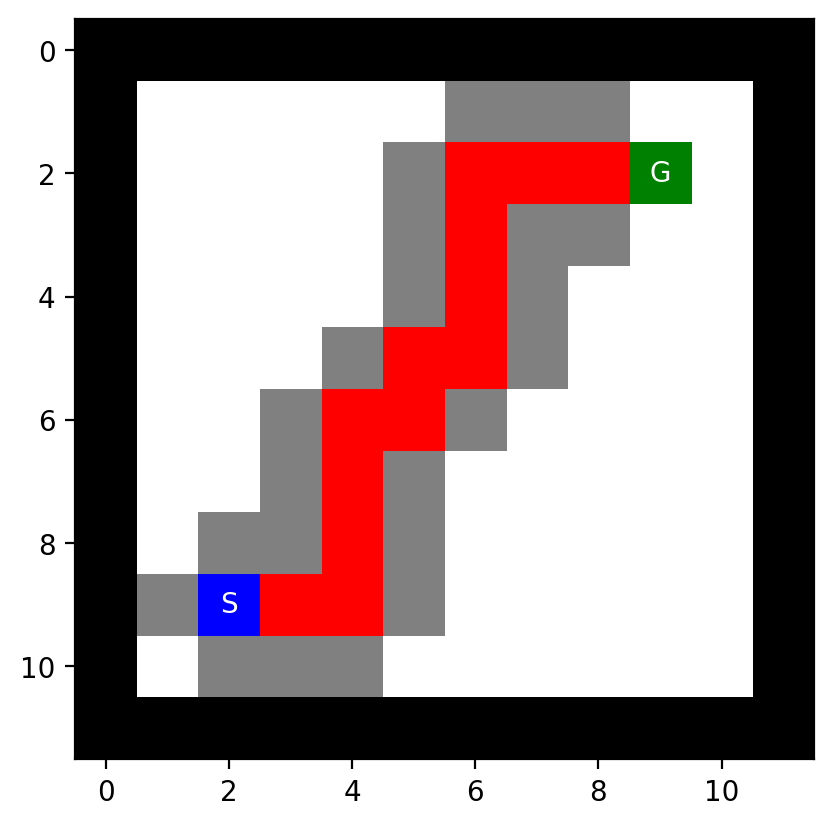

Maze: empty2
Path Cost: 14
Squares Explored: 36
Frontier Maximum: 22
Depth Maximum: 14


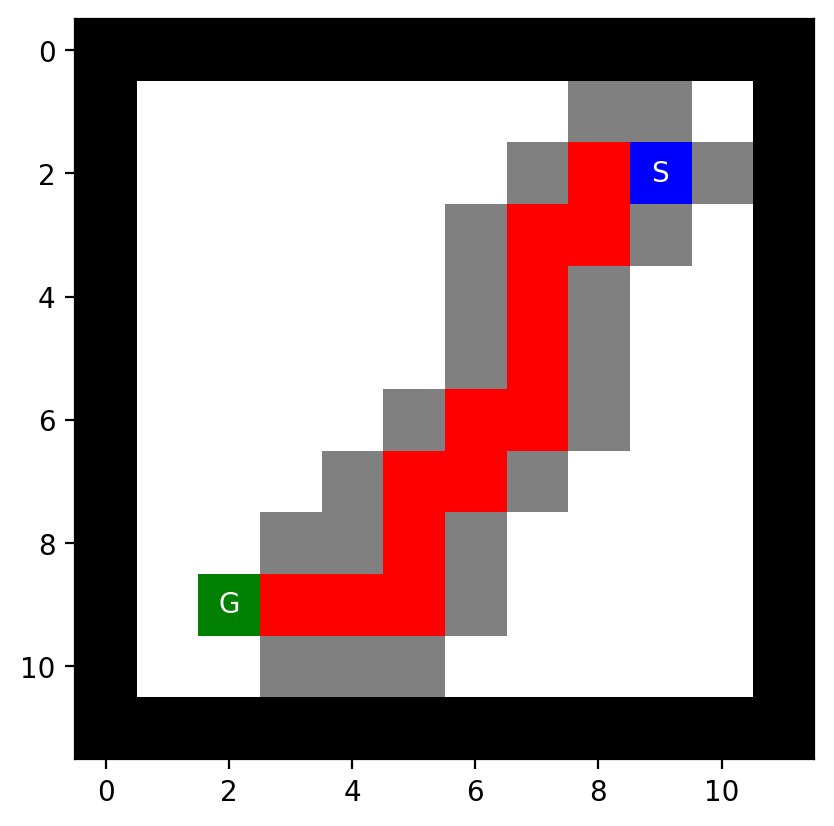

Maze: wall
Path Cost: 14
Squares Explored: 43
Frontier Maximum: 24
Depth Maximum: 14


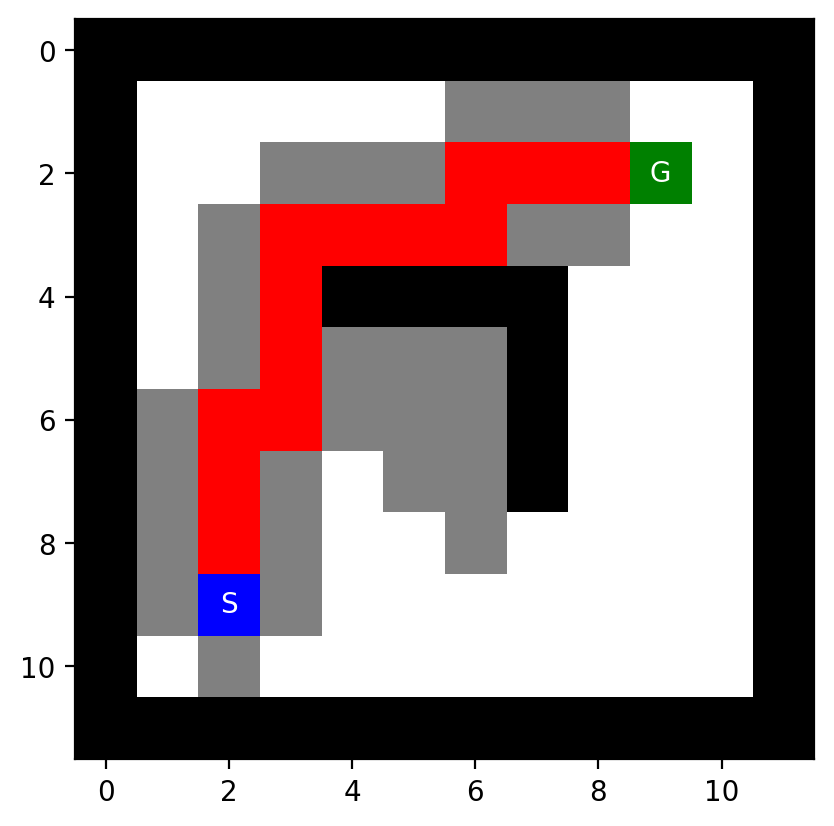

Maze: loops
Path Cost: 23
Squares Explored: 61
Frontier Maximum: 12
Depth Maximum: 23


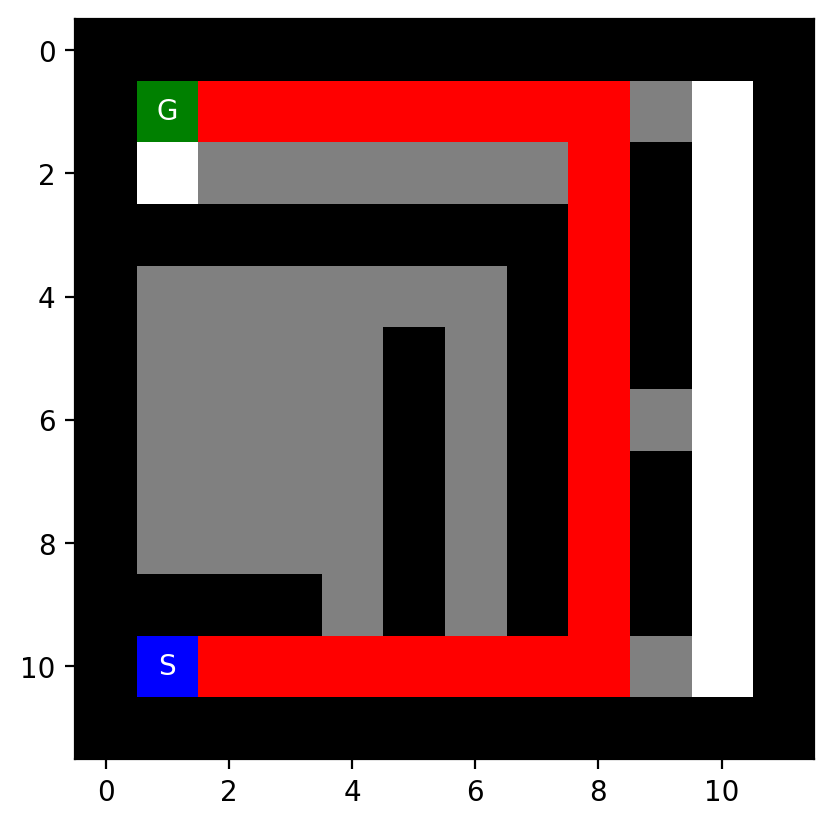


Strategy: A*

Maze: small
Path Cost: 19
Squares Explored: 59
Frontier Maximum: 8
Depth Maximum: 19


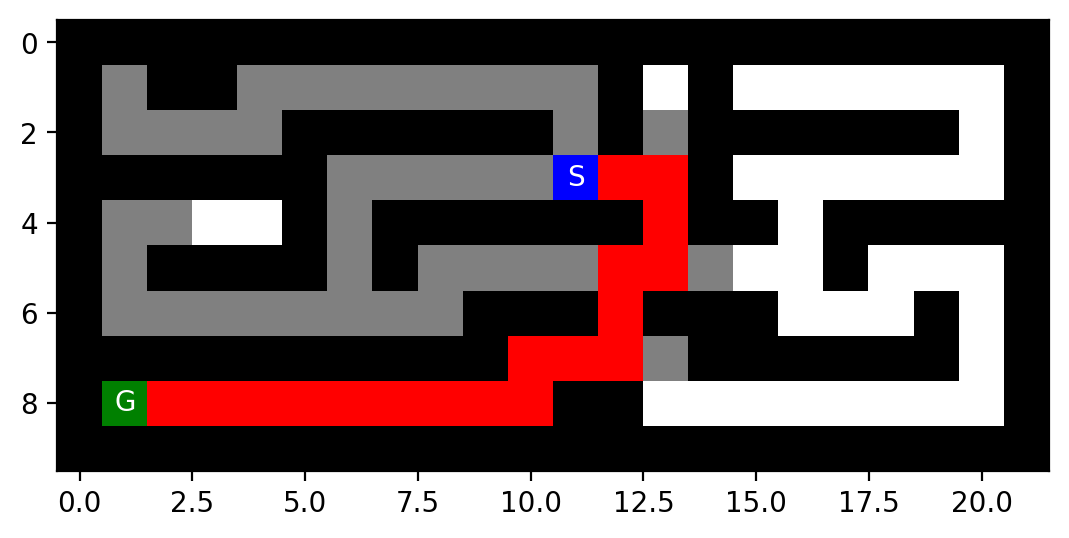

Maze: medium
Path Cost: 68
Squares Explored: 228
Frontier Maximum: 8
Depth Maximum: 68


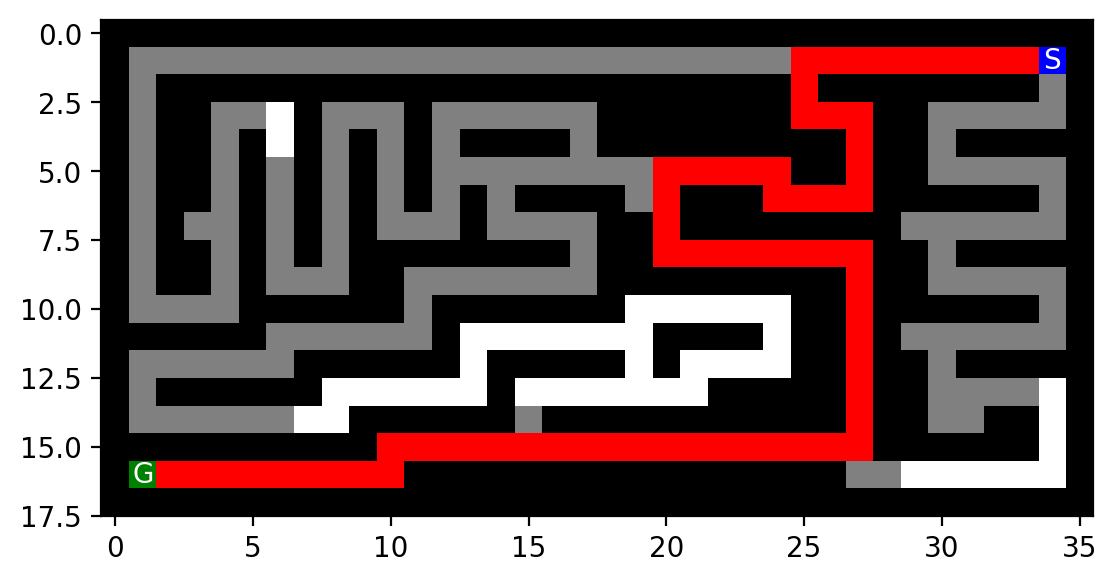

Maze: large
Path Cost: 210
Squares Explored: 557
Frontier Maximum: 13
Depth Maximum: 210


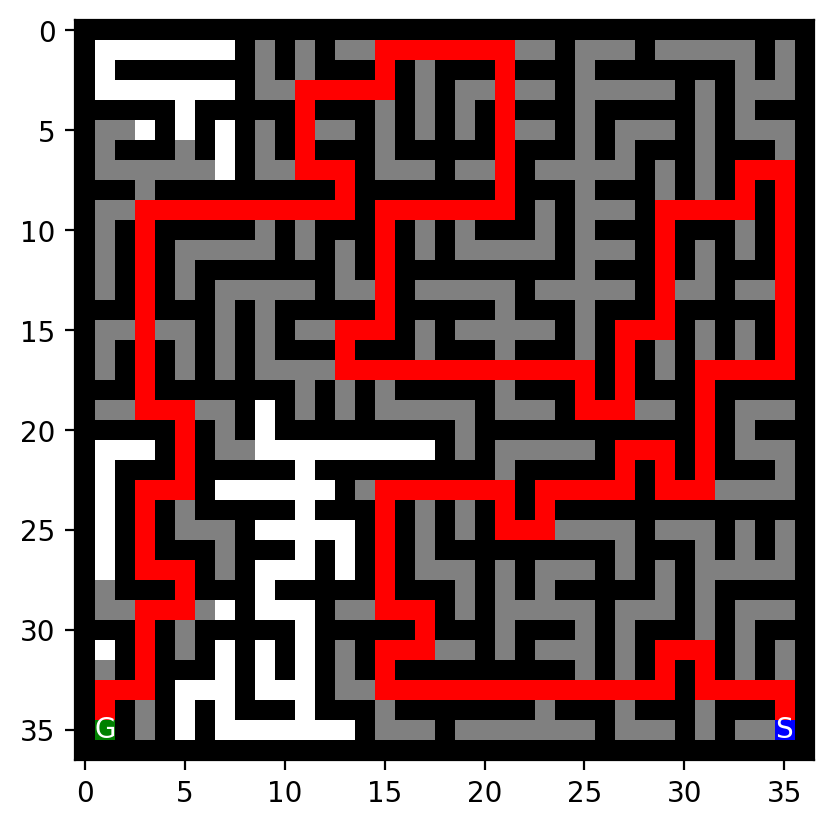

Maze: open
Path Cost: 54
Squares Explored: 366
Frontier Maximum: 86
Depth Maximum: 54


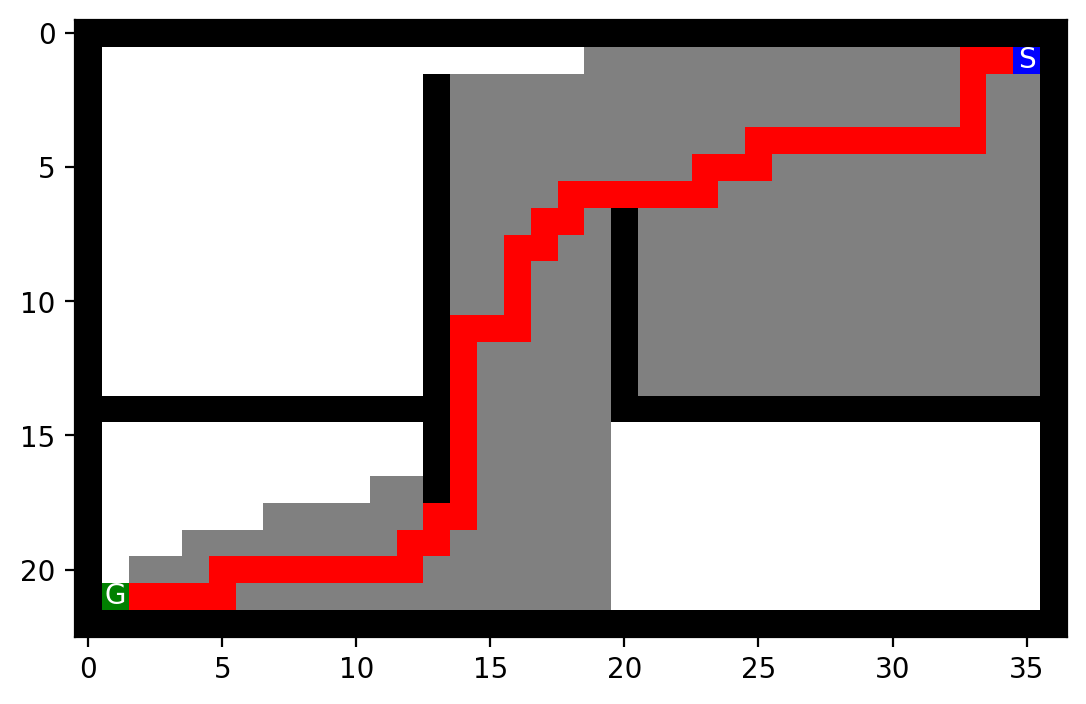

Maze: empty
Path Cost: 14
Squares Explored: 71
Frontier Maximum: 33
Depth Maximum: 14


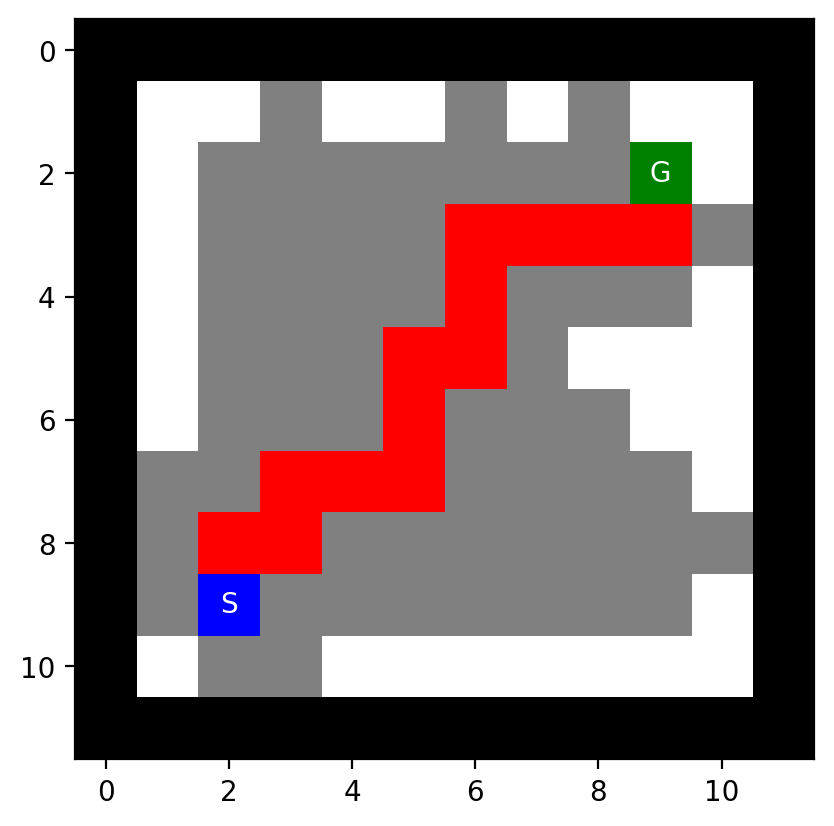

Maze: empty2
Path Cost: 14
Squares Explored: 78
Frontier Maximum: 31
Depth Maximum: 14


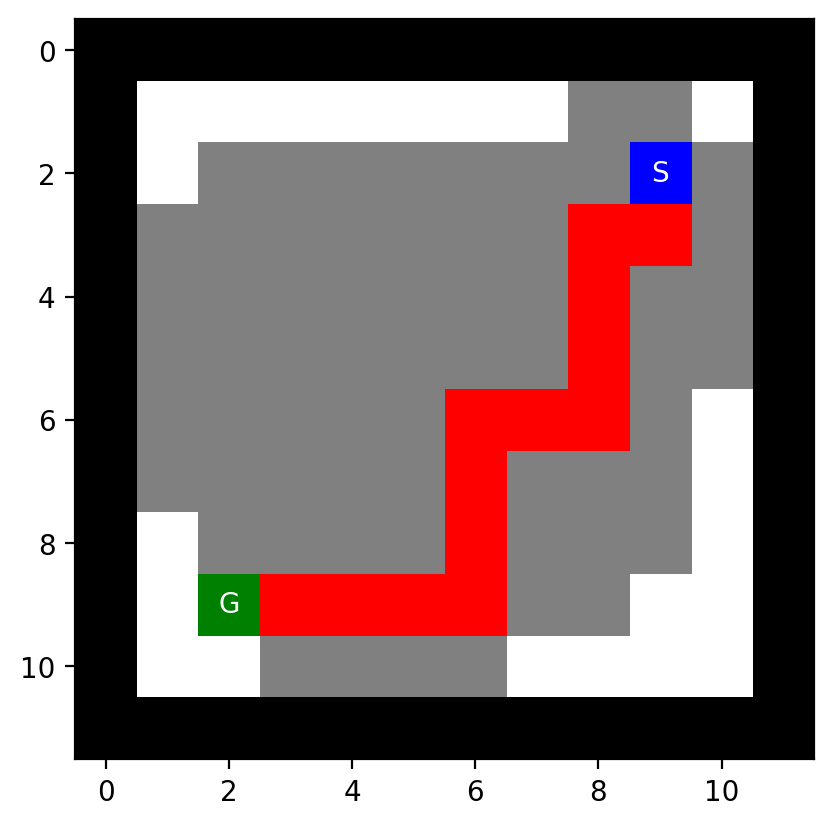

Maze: wall
Path Cost: 14
Squares Explored: 69
Frontier Maximum: 32
Depth Maximum: 14


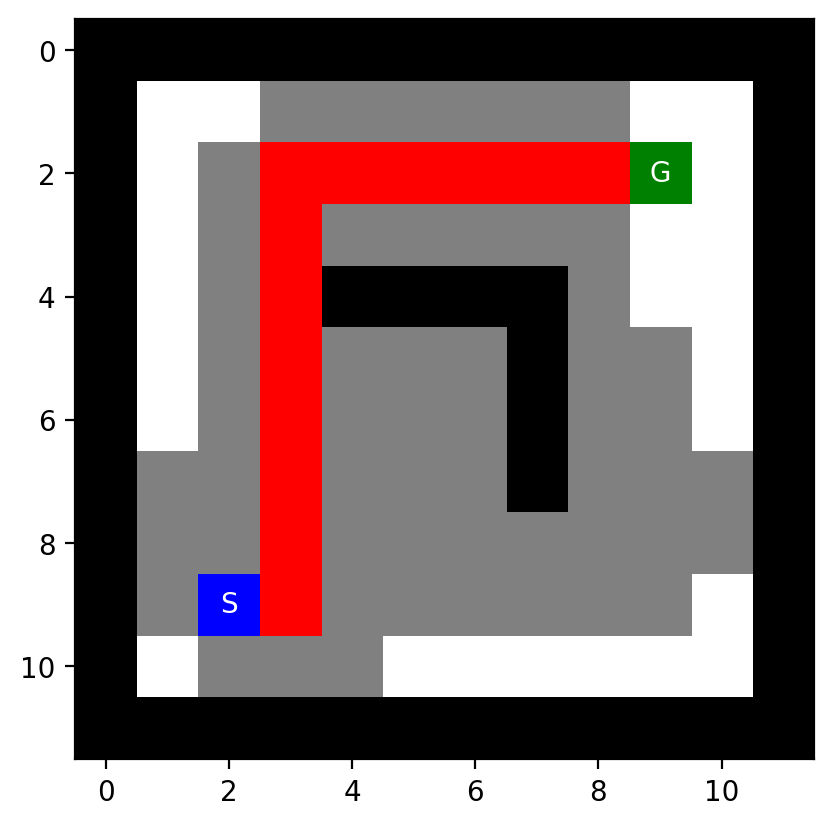

Maze: loops
Path Cost: 23
Squares Explored: 61
Frontier Maximum: 8
Depth Maximum: 23


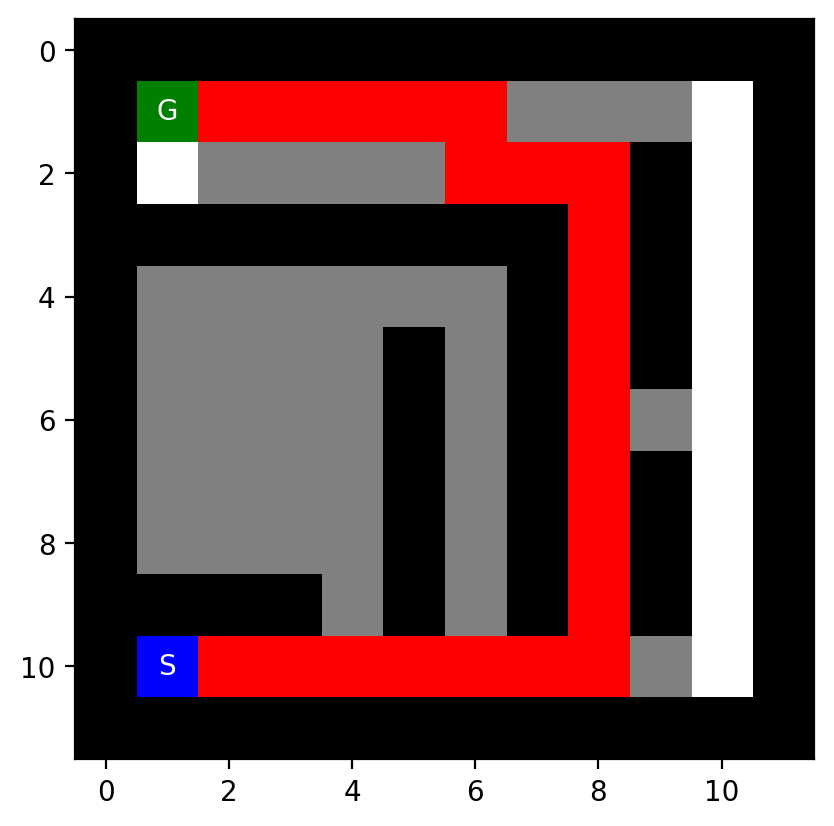

In [535]:
# Your code goes here
def task3_search(maze, search_method = "GBFS"):

    #Find the initial state position and the goal state position
    start_pos = mh.find_pos(maze, "S")
    end_pos = mh.find_pos(maze, "G")
        
    #Initial state position becomes root node
    root = Node(pos=start_pos, parent=None, action=None, cost=0)

    #Creating the frontier for the search
    frontier = []
    frontier.append(root)

    #Creating list of nodes that have been visited
    reached = dict()
    reached[tuple(root.pos)] = root

    #Keeping track of the maximum frontier and depth
    frontier_maximum = 0
    depth_maximum = 0
    
    #Set the current node as the root node
    node = root
    
    #Keep searching until the goal state is reached or if nothing remains in the frontier
    while not (len(frontier) < 1):

        #Continue to update frontier maximum if necessary
        if(len(frontier) > frontier_maximum):
            frontier_maximum = len(frontier)

        #Using search method to move forward on the frontier
        if(search_method == "GBFS"):
            h_n = [manhattan_dis(n.pos, end_pos) for n in frontier]
            node = frontier.pop(least_steps(h_n))

        elif(search_method == "A*"):
            f_n = [g(n) + manhattan_dis(n.pos, end_pos) for n in frontier]
            node = frontier.pop(least_steps(f_n))

        else:
            print("Strategy does not exist.")
            return(None)
        
        #Check to see if the goal state has been reached
        if(mh.look(maze, node.pos) == "G"):
            return({
                "path": node.get_path_from_root(),
                "reached": reached.keys(),
                "frontier-maximum": frontier_maximum,
                "depth-maximum": depth_maximum
            })
        
        #Continue expanding from current node if not at goal state
        else:
            #Check what actions can be performed
            for position in possible_positions(maze, node.pos):
                #If an available and ideal action takes you to a visited node, do not add to frontier to prevent looping in search
                if(search_method in ["GBFS"]):
                    if(tuple(position) in reached.keys()):
                        if(g(reached[tuple(position)]) <= g(node) + 1):
                            continue

                elif(tuple(position) in reached.keys()):
                    continue

                #If the successive position is not yet on the frontier or is a better node for the frontier, add it to frontier
                n = Node(pos=position, parent=node, action=None, cost=1)

                if(g(n) > depth_maximum):
                    depth_maximum = g(n)
                frontier.append(n)
                reached[tuple(position)] = n
                
    return(None)

def test_maze3(methods):
    print()
    for method in methods:
        print(f"Strategy: {method}")
        print()
        for search_maze in mazes.keys():
            maze = load_maze(search_maze)
            results = task3_search(maze, search_method=method)
            print("Maze: {}".format(search_maze))
            print("Path Cost: {}".format(len(results["path"])-1))
            print("Squares Explored: {}".format(len(results["reached"])))
            print("Frontier Maximum: {}".format(results["frontier-maximum"]))
            print("Depth Maximum: {}".format(results["depth-maximum"]))
            show_path(maze, results["path"], results["reached"])
        print()

search_methods = ["GBFS", "A*"]
test_maze3(search_methods)

Are your implementations complete and optimal? What is the time and space complexity?

# Discussion
GBFS: GBFS is complete. This is because the search using GBFS keeps track of what nodes have been visited already. GBFS is not optimal because once it commits to going down a path, even if it has dead ends or other misleading obstacles, it may not recover or explore other possibilities. The Manhattan heuristic function do not consider these misleading factors, thus causing the agent to potentially fail at finding the goal state. The time complexity of GBFS varies on the case. In the worst case scenario, GBFS has time complexity $O(b^m)$. In the best case scenario, GBFS has time complexity $O(bd)$. A strong heuristic function can help improve the time complexity by helping the search weigh the costs between which path to go down on. The space complexity of GBFS is the same as the time complexity. In the worst case scenario, GBFS has time complexity $O(b^m)$. In the best case scenario, GBFS has time complexity $O(bd)$. For same reason as time complexity, a strong heuristic function is what can help improve the space complexity.

A*: A* is complete. This is because the search using A* does not overestimate the cost of searching for the goal state and there are a finite number of nodes to work with in the maze. A* is also optimal because the Manhattan heuristic function is admissible. The time complexity of A* search is $O(b^d)$. This comes from searching approximately $d$ levels and $b$ branches from each node at each level it searches. $d$ is the depth of the solution but also represents a rough estimate of the cost of the heuristic function used for the A* search. The heuristic function affects both the time and space complexity of A* search like it does with GBFS. Thus, the space complexity is also $O(b^d)$.

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.


Strategy: BFS

Maze: small
Path Cost: 19
Squares Explored: 93
Frontier Maximum: 8
Depth Maximum: 19


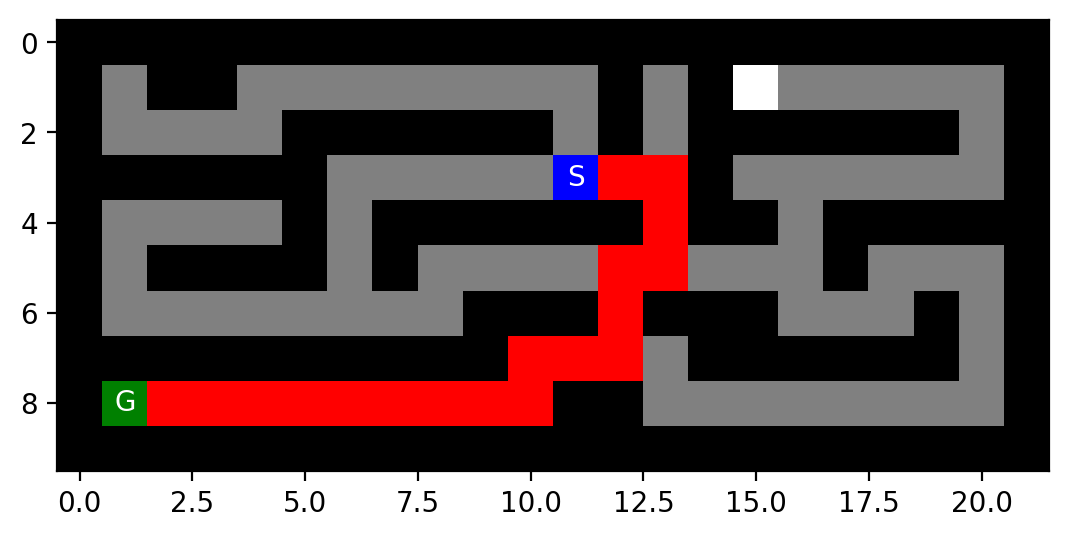

Maze: medium
Path Cost: 68
Squares Explored: 273
Frontier Maximum: 9
Depth Maximum: 69


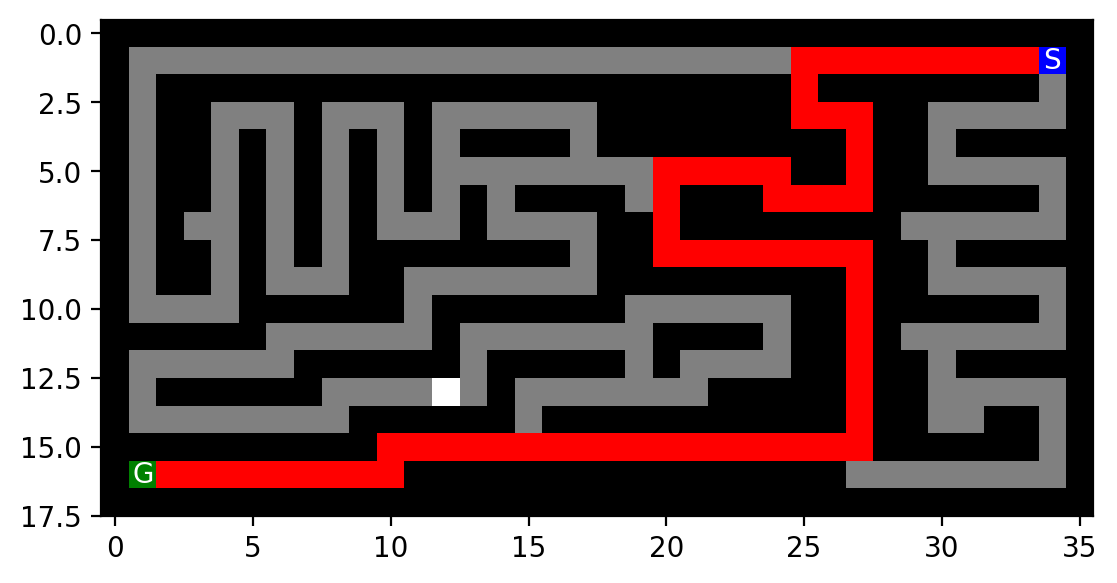

Maze: large
Path Cost: 210
Squares Explored: 625
Frontier Maximum: 8
Depth Maximum: 211


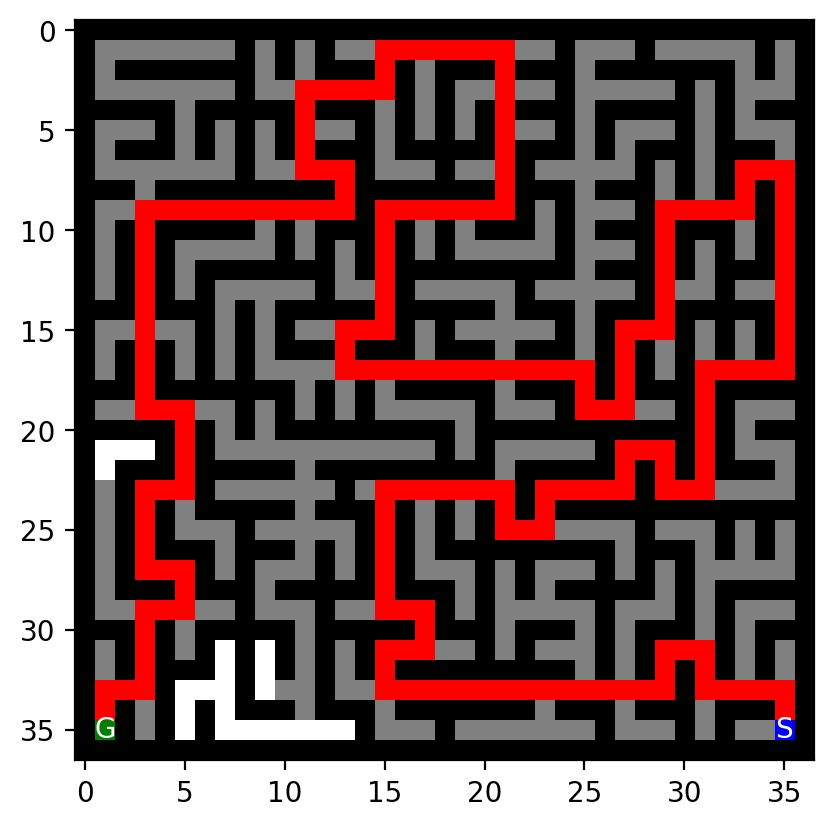

Maze: open
Path Cost: 54
Squares Explored: 684
Frontier Maximum: 25
Depth Maximum: 54


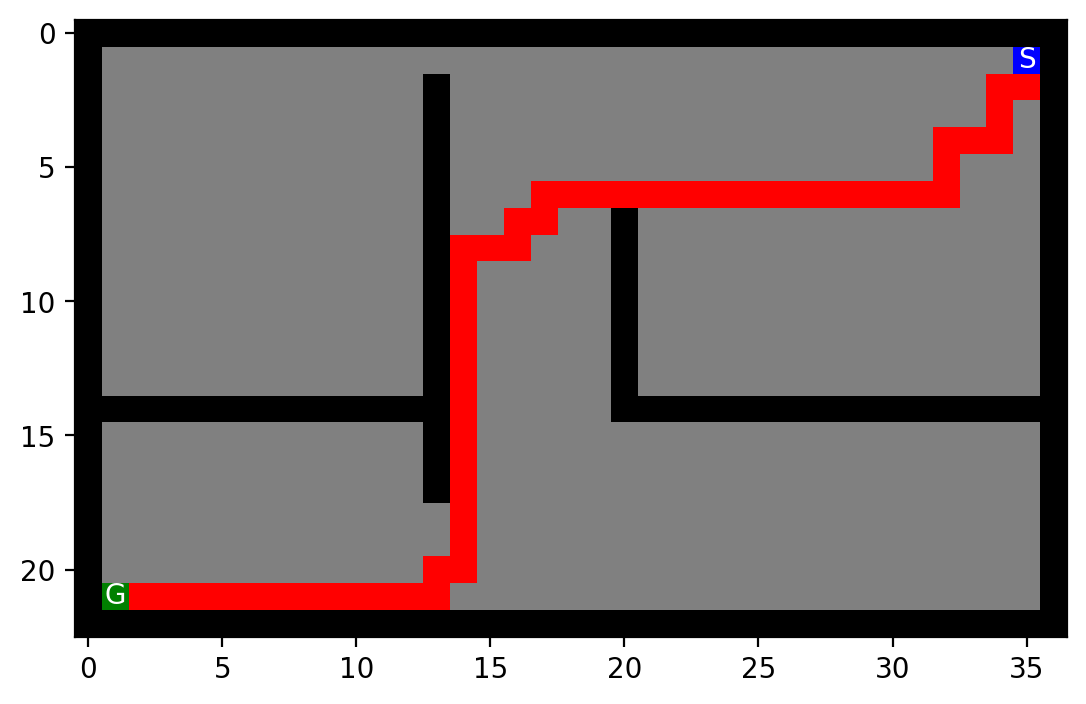

Maze: empty
Path Cost: 14
Squares Explored: 98
Frontier Maximum: 12
Depth Maximum: 15


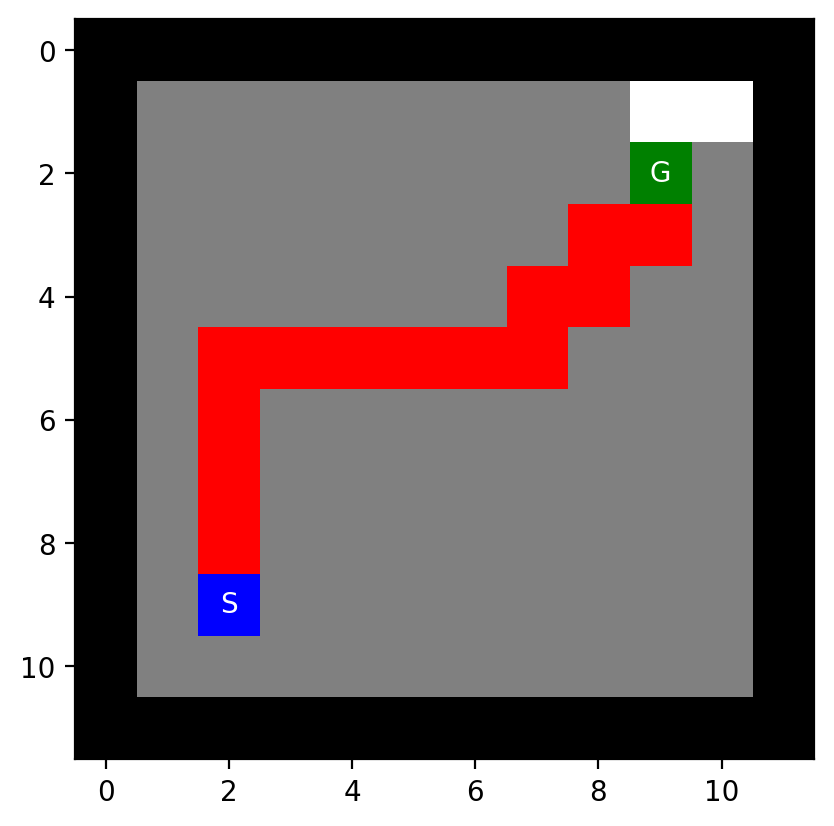

Maze: empty2
Path Cost: 14
Squares Explored: 98
Frontier Maximum: 12
Depth Maximum: 15


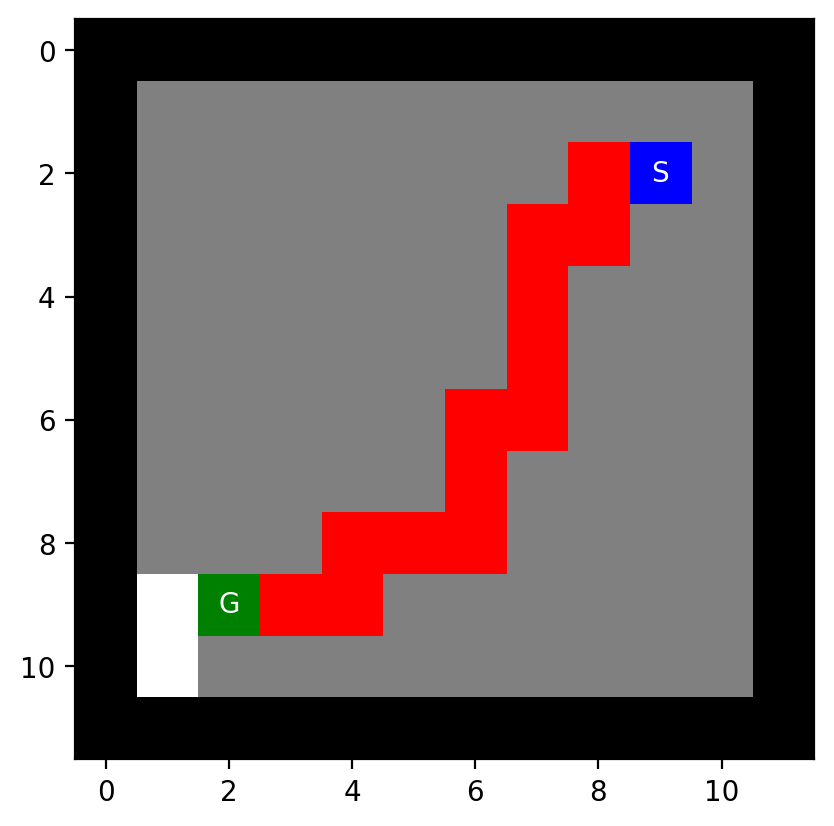

Maze: wall
Path Cost: 14
Squares Explored: 91
Frontier Maximum: 10
Depth Maximum: 15


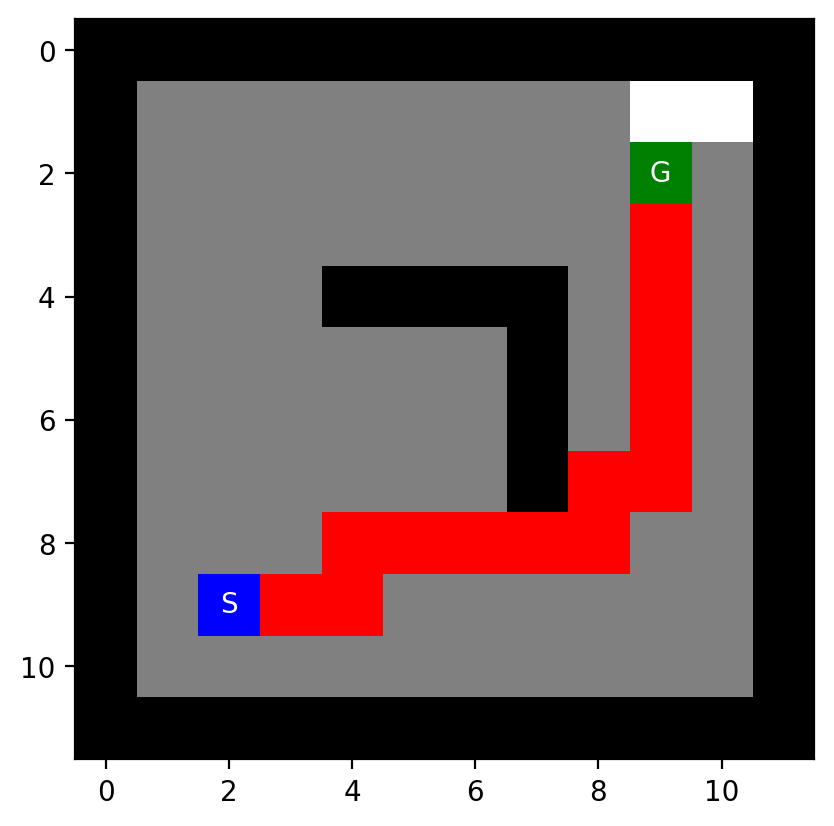

Maze: loops
Path Cost: 23
Squares Explored: 72
Frontier Maximum: 8
Depth Maximum: 23


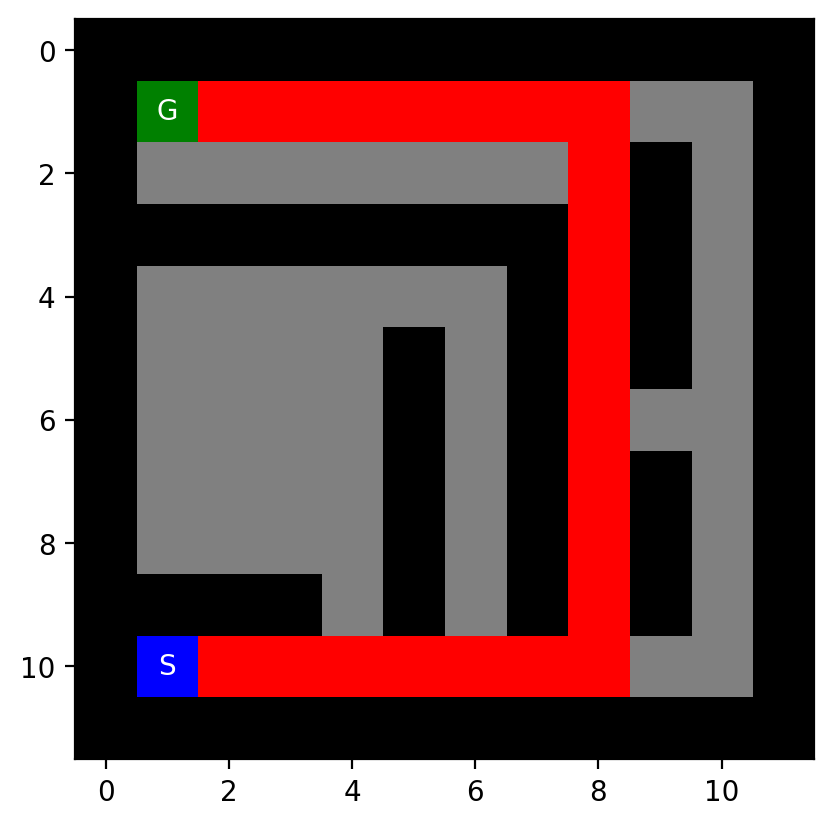


Strategy: DFS

Maze: small
Path Cost: 49
Squares Explored: 69
Frontier Maximum: 6
Depth Maximum: 49


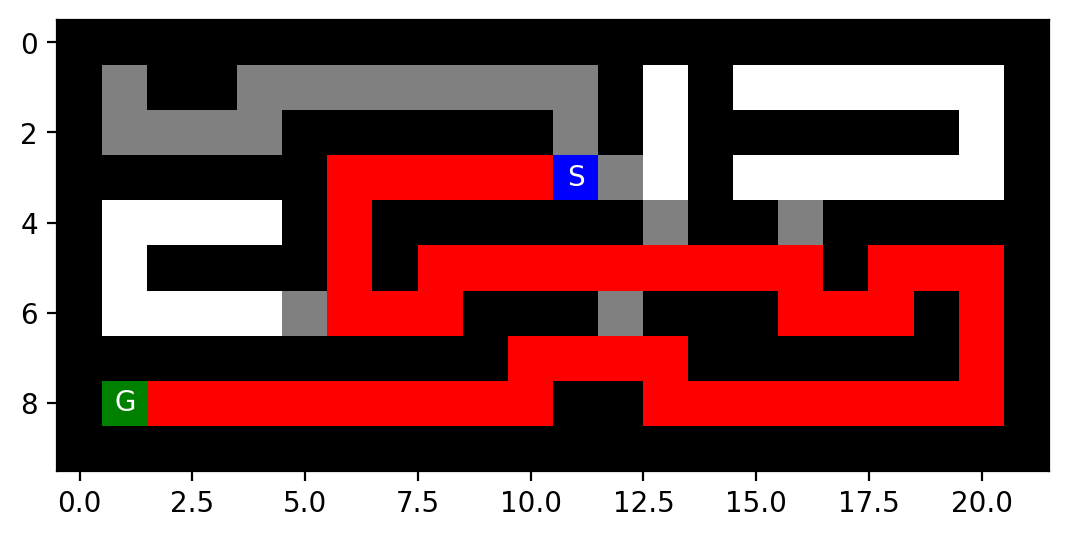

Maze: medium
Path Cost: 234
Squares Explored: 274
Frontier Maximum: 10
Depth Maximum: 234


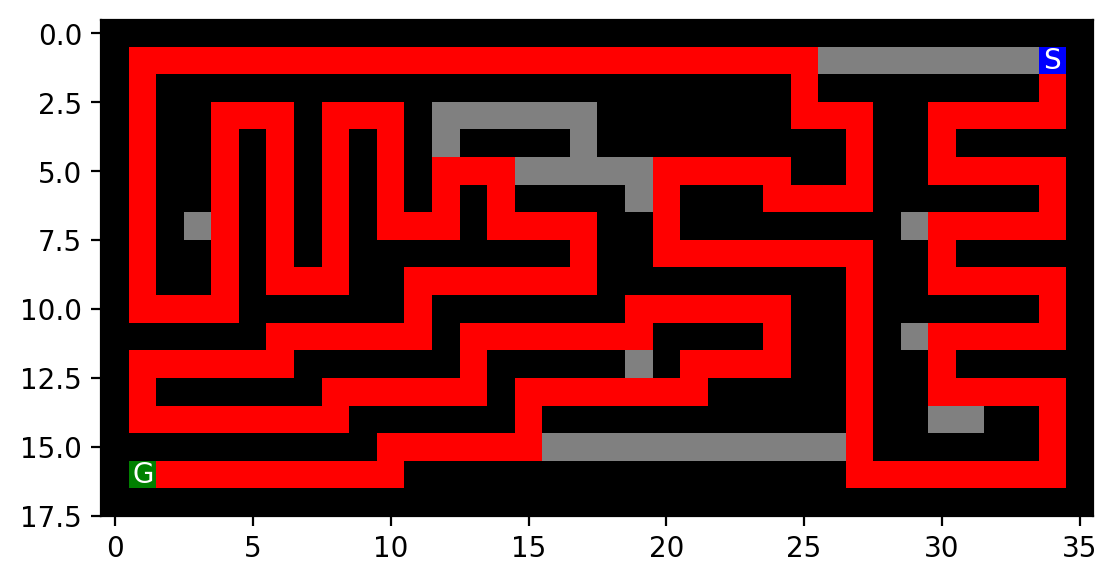

Maze: large
Path Cost: 210
Squares Explored: 421
Frontier Maximum: 29
Depth Maximum: 210


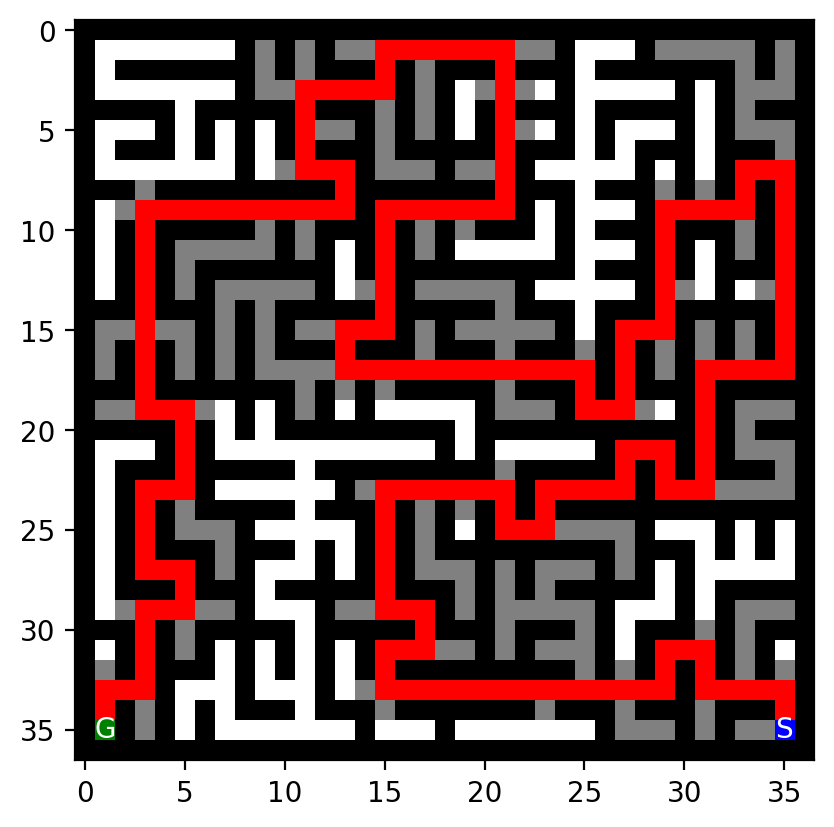

Maze: open
Path Cost: 126
Squares Explored: 357
Frontier Maximum: 138
Depth Maximum: 146


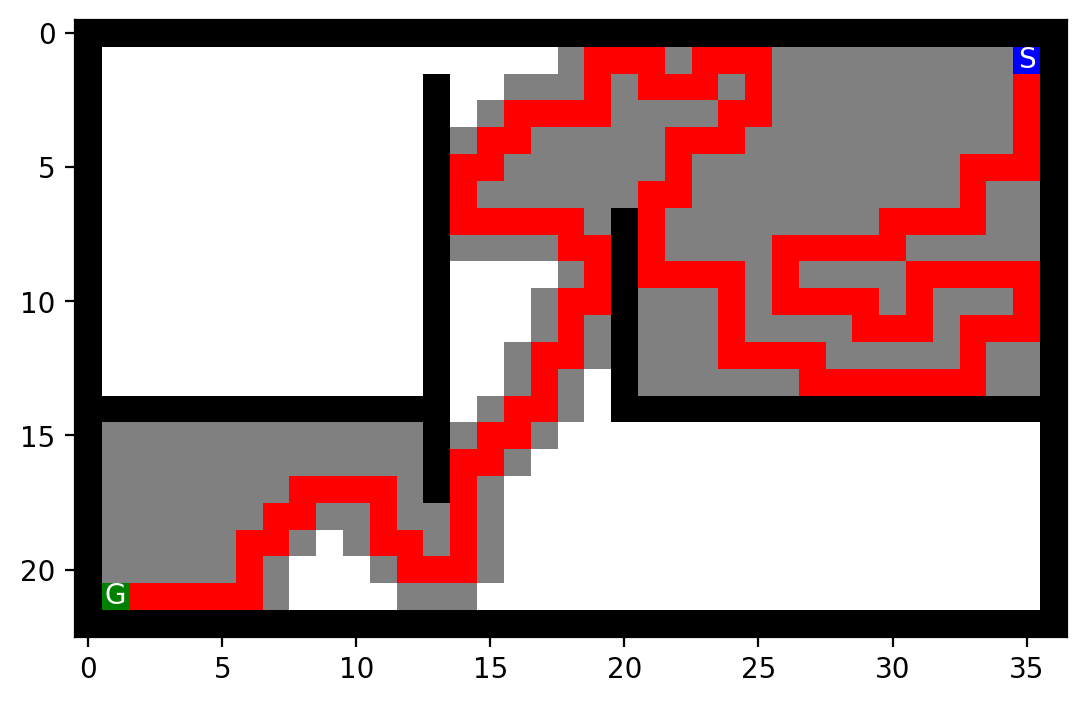

Maze: empty
Path Cost: 44
Squares Explored: 94
Frontier Maximum: 40
Depth Maximum: 44


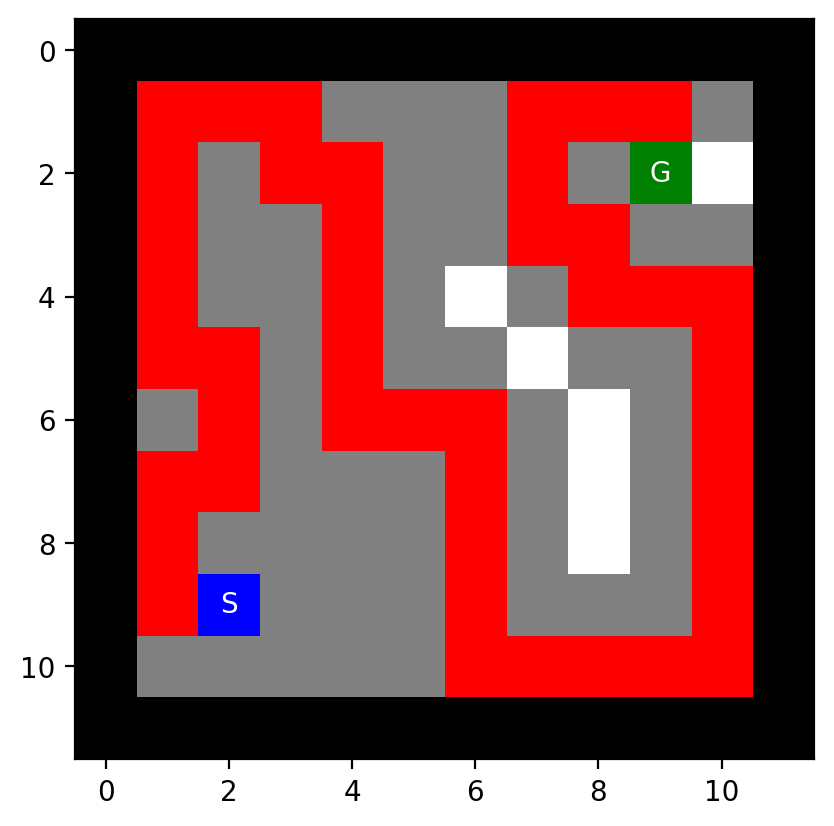

Maze: empty2
Path Cost: 46
Squares Explored: 91
Frontier Maximum: 38
Depth Maximum: 46


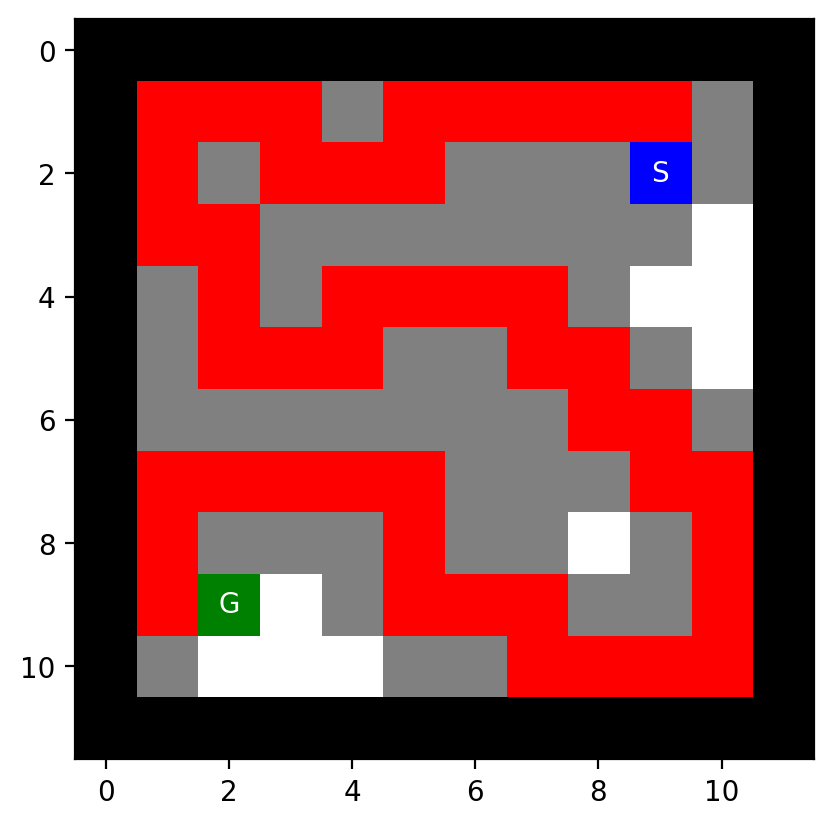

Maze: wall
Path Cost: 46
Squares Explored: 84
Frontier Maximum: 34
Depth Maximum: 50


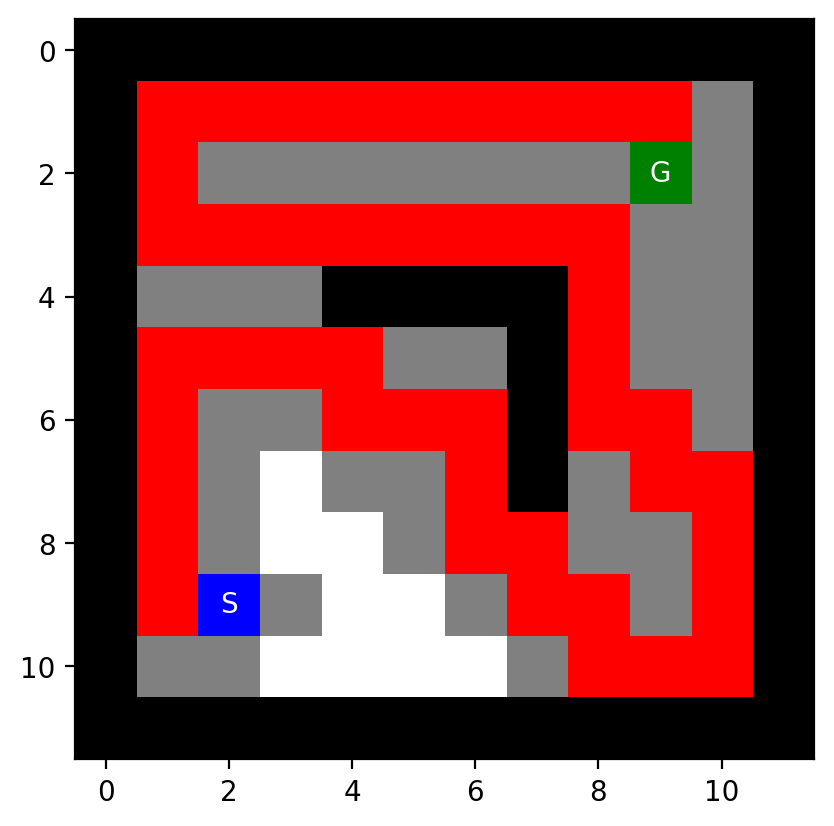

Maze: loops
Path Cost: 25
Squares Explored: 71
Frontier Maximum: 10
Depth Maximum: 27


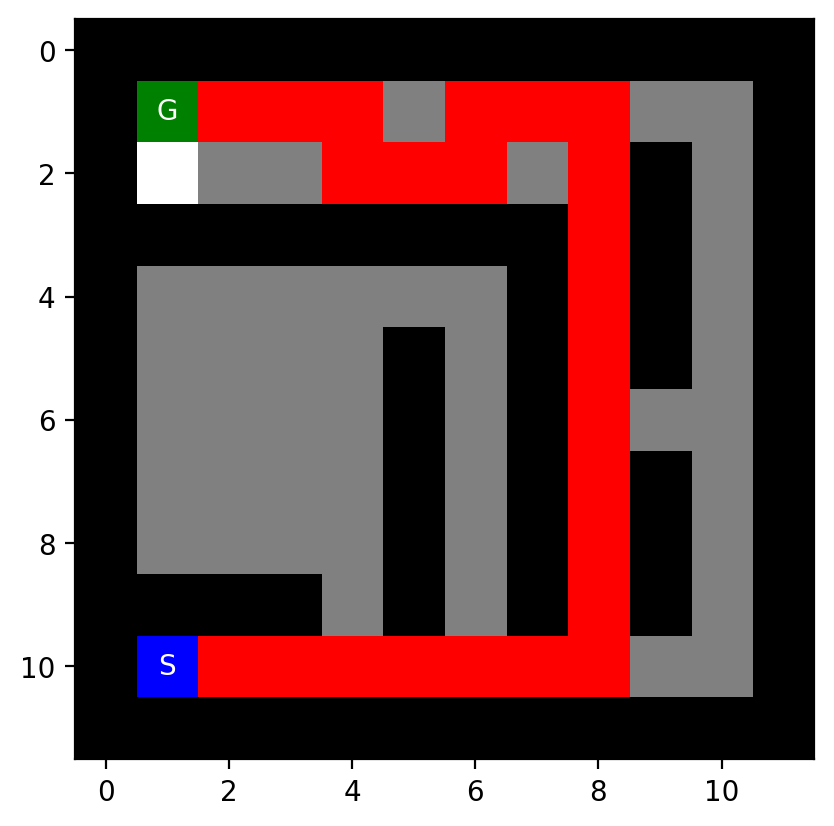



Strategy: GBFS

Maze: small
Path Cost: 29
Squares Explored: 44
Frontier Maximum: 5
Depth Maximum: 29


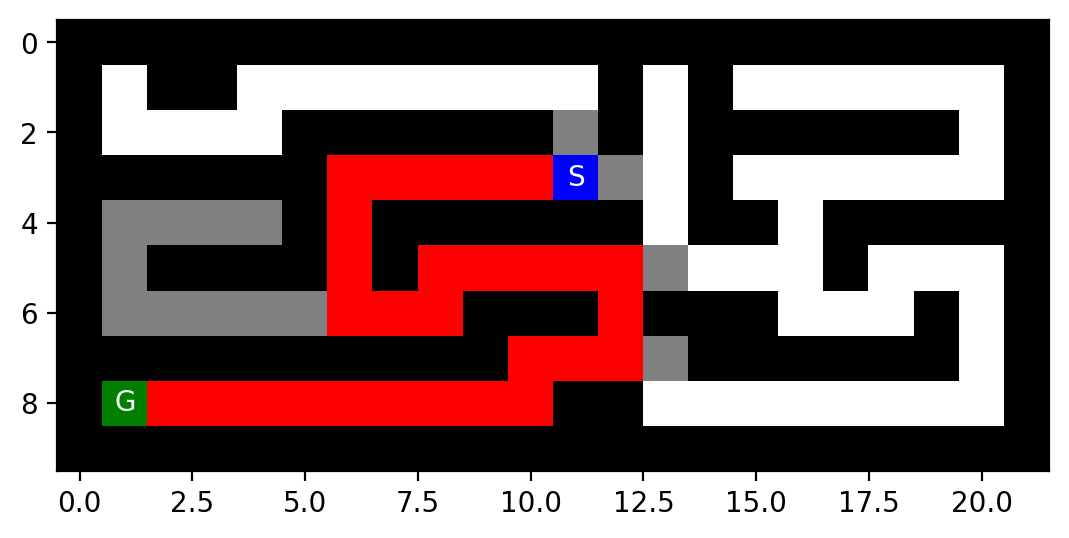

Maze: medium
Path Cost: 74
Squares Explored: 82
Frontier Maximum: 4
Depth Maximum: 74


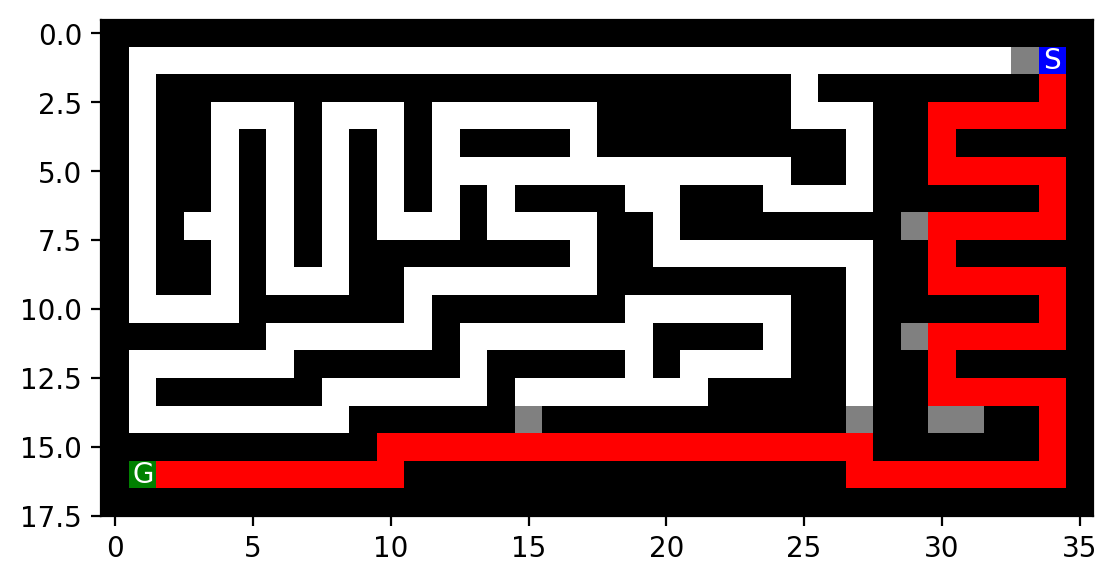

Maze: large
Path Cost: 210
Squares Explored: 475
Frontier Maximum: 26
Depth Maximum: 210


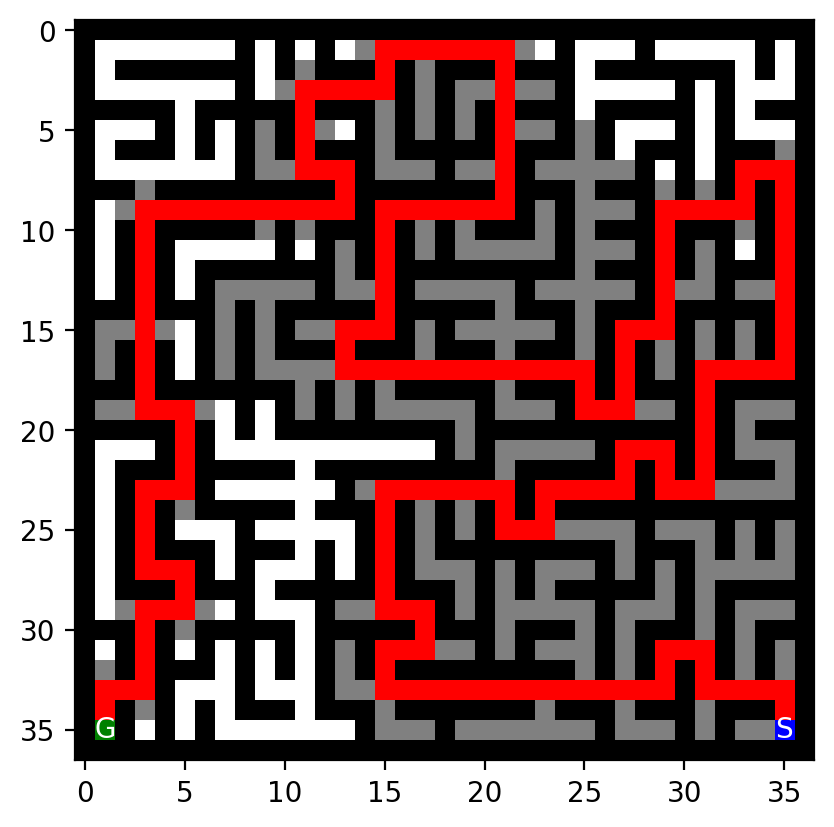

Maze: open
Path Cost: 66
Squares Explored: 159
Frontier Maximum: 81
Depth Maximum: 66


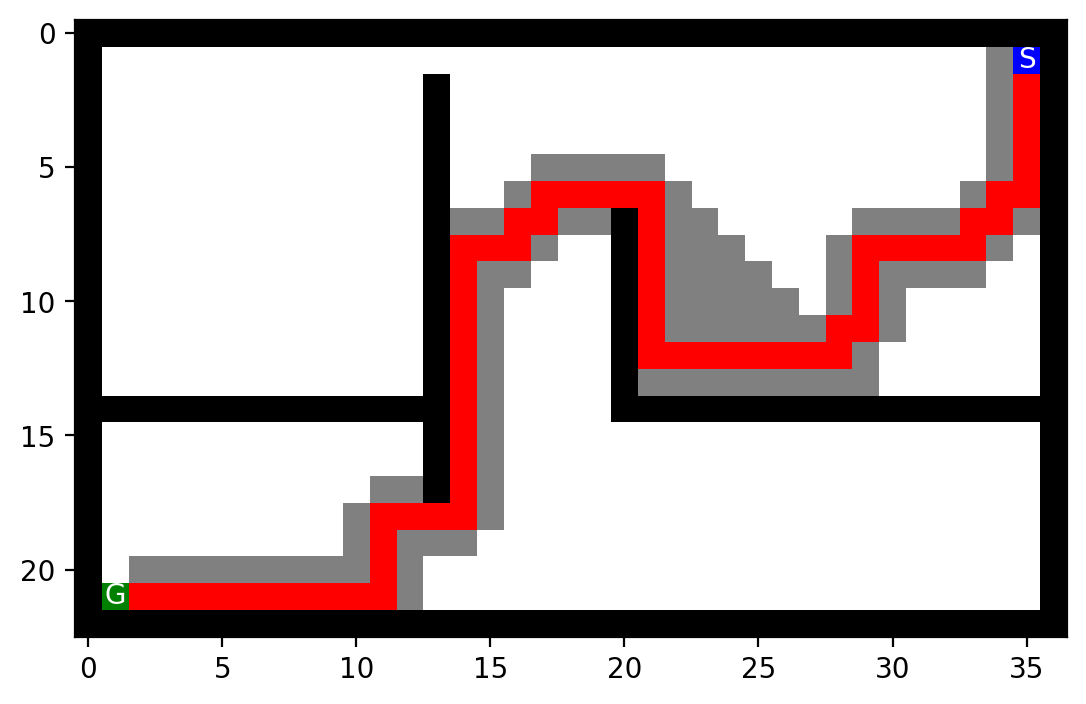

Maze: empty
Path Cost: 14
Squares Explored: 39
Frontier Maximum: 25
Depth Maximum: 14


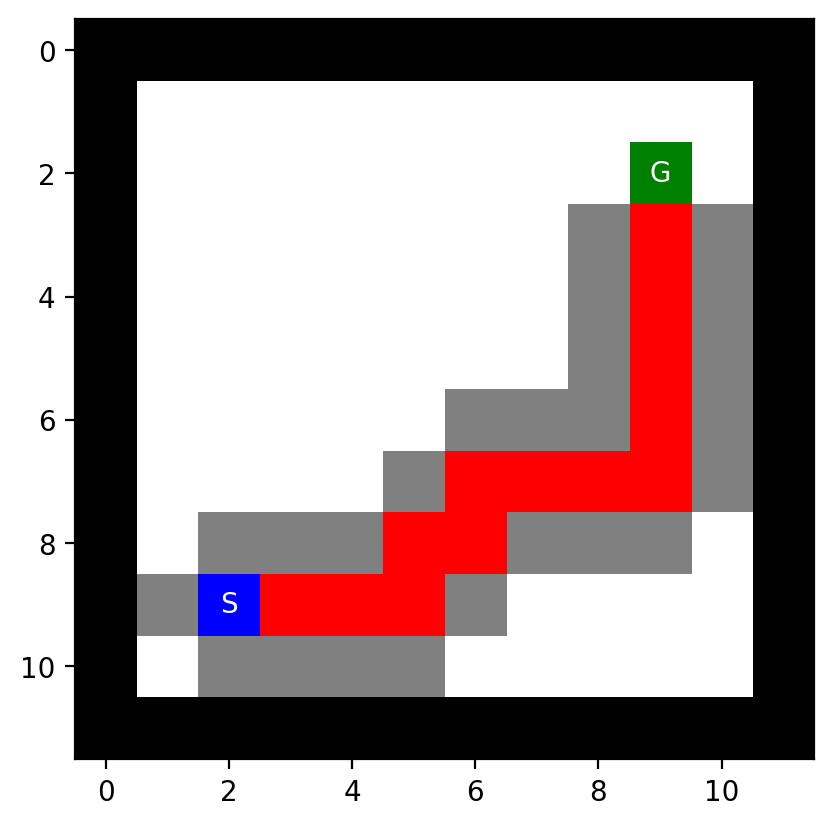

Maze: empty2
Path Cost: 14
Squares Explored: 36
Frontier Maximum: 22
Depth Maximum: 14


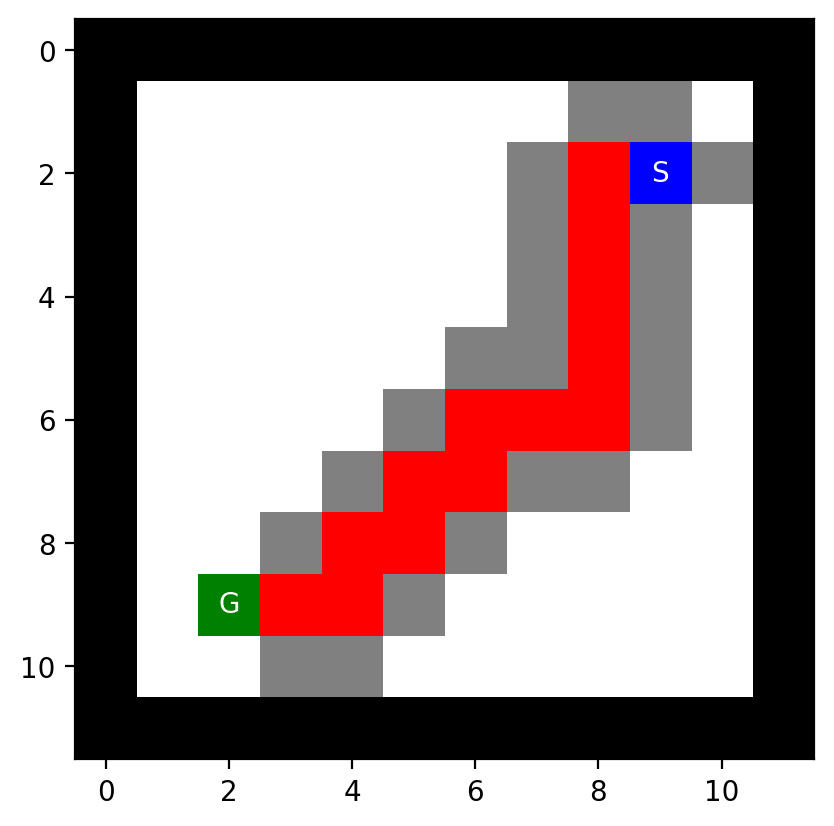

Maze: wall
Path Cost: 16
Squares Explored: 48
Frontier Maximum: 27
Depth Maximum: 16


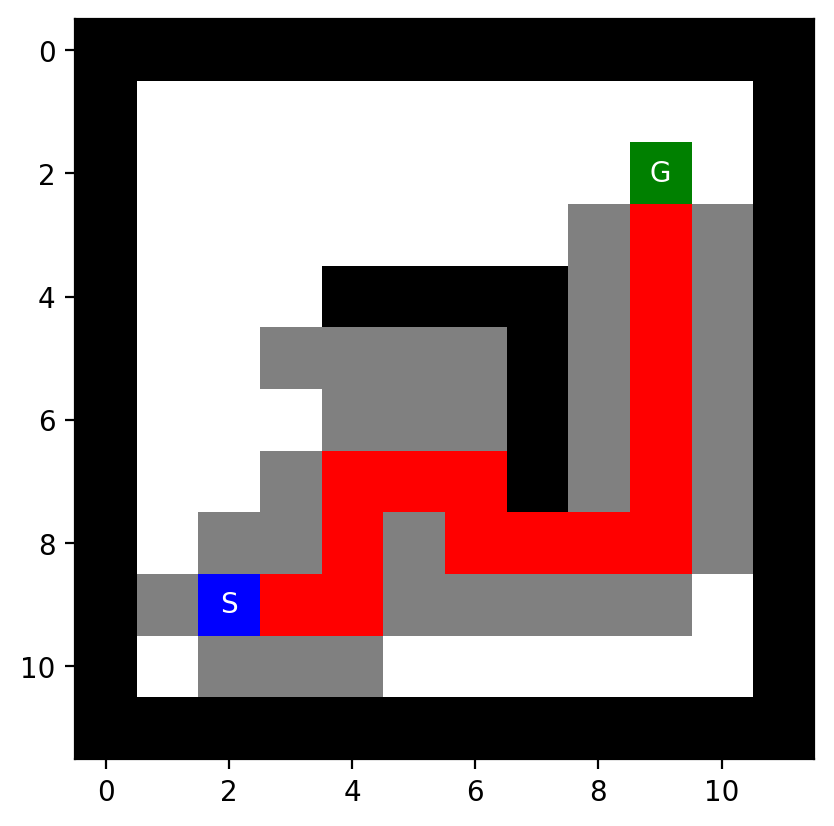

Maze: loops
Path Cost: 23
Squares Explored: 61
Frontier Maximum: 11
Depth Maximum: 23


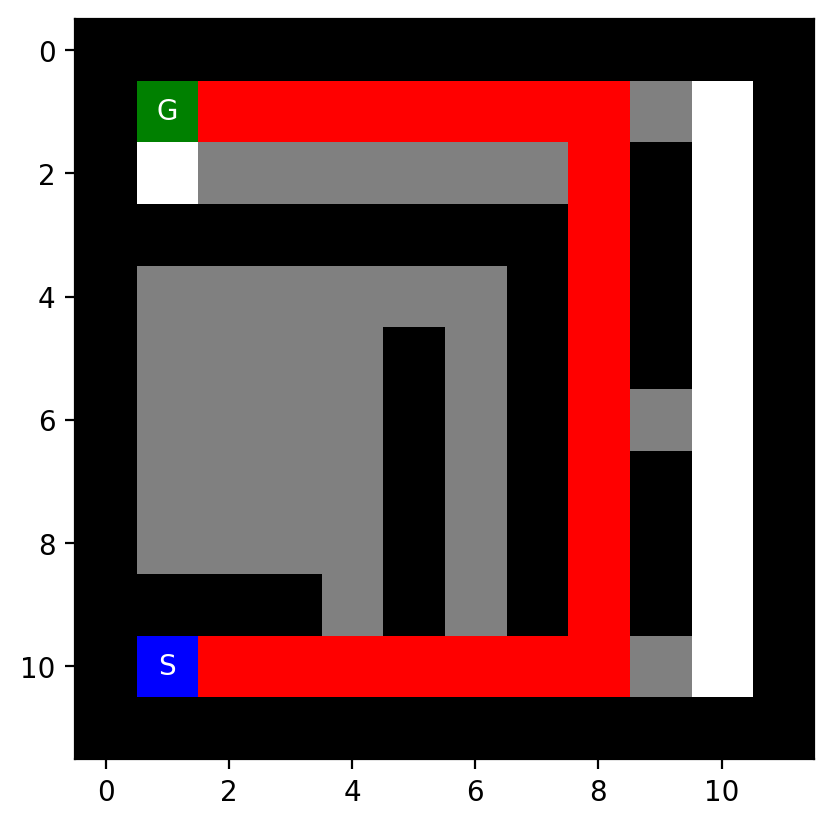


Strategy: A*

Maze: small
Path Cost: 19
Squares Explored: 59
Frontier Maximum: 8
Depth Maximum: 19


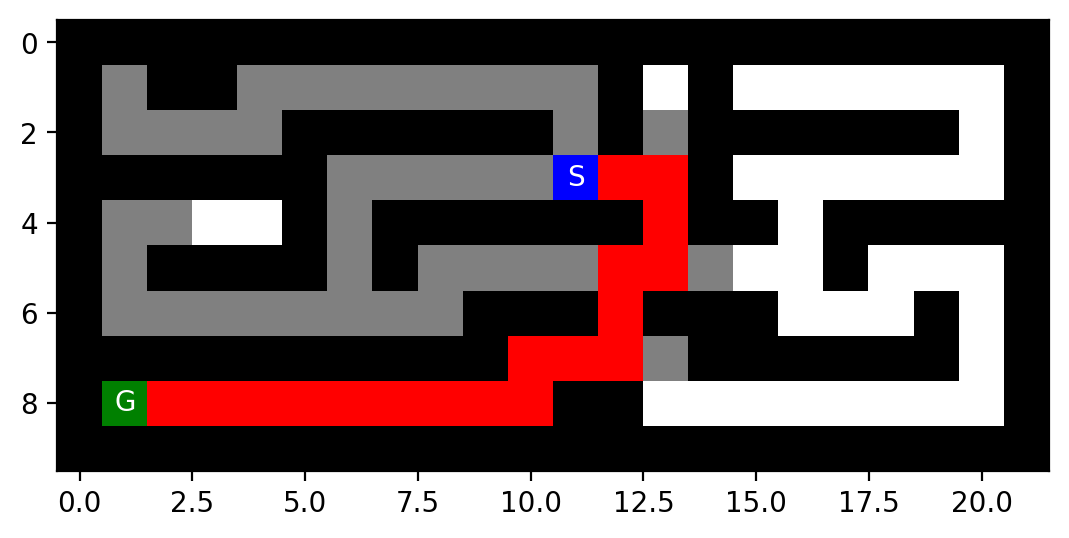

Maze: medium
Path Cost: 68
Squares Explored: 228
Frontier Maximum: 8
Depth Maximum: 68


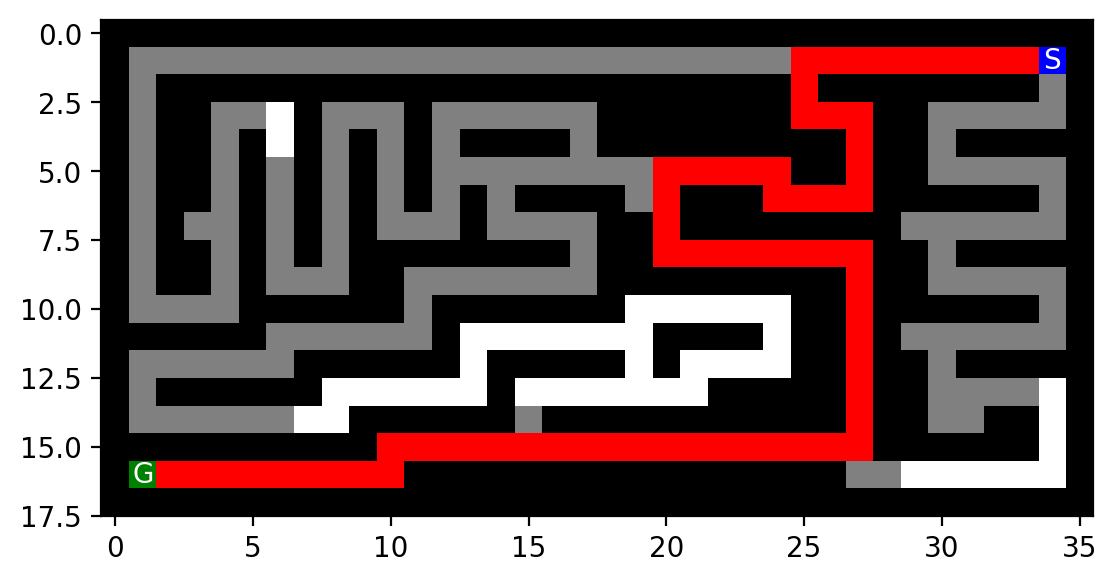

Maze: large
Path Cost: 210
Squares Explored: 557
Frontier Maximum: 12
Depth Maximum: 210


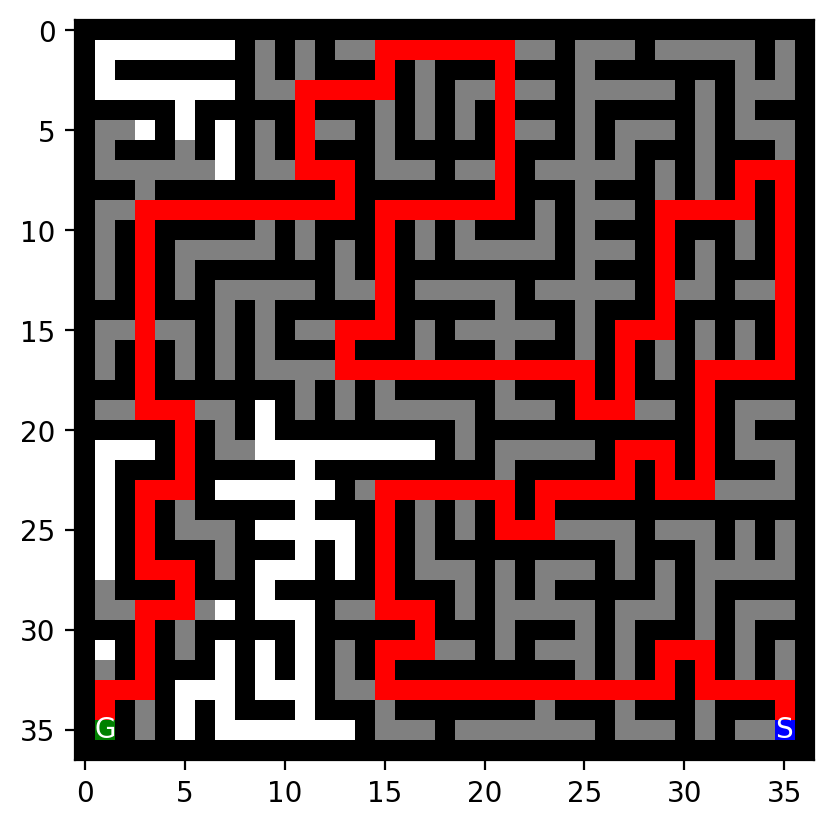

Maze: open
Path Cost: 54
Squares Explored: 371
Frontier Maximum: 101
Depth Maximum: 54


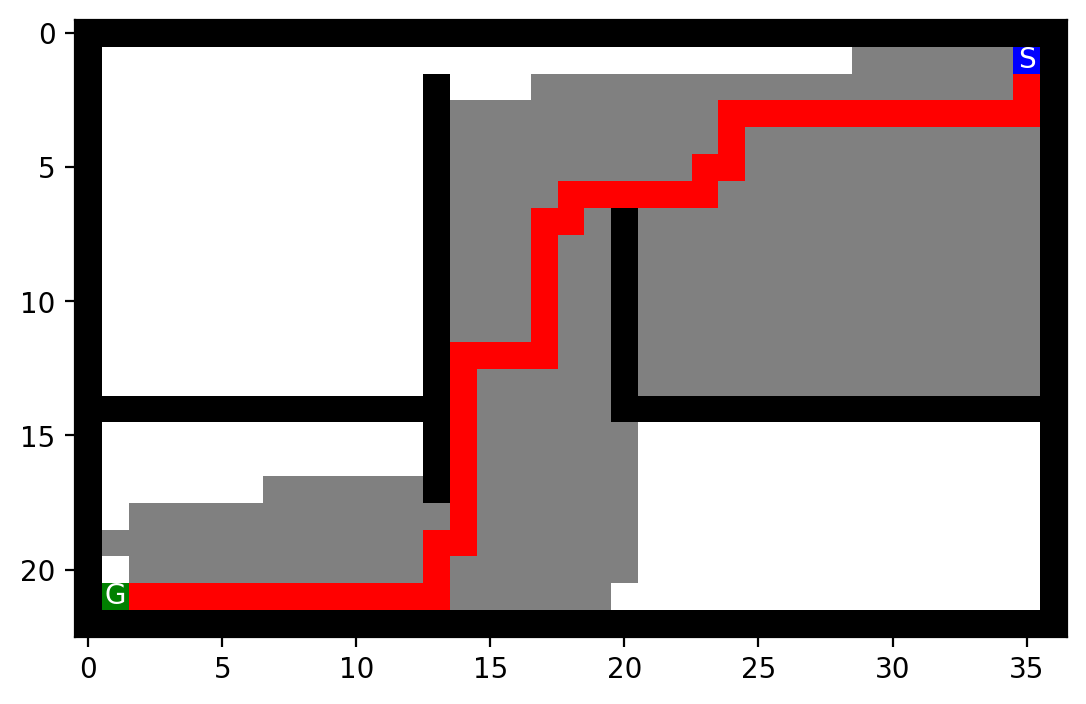

Maze: empty
Path Cost: 14
Squares Explored: 82
Frontier Maximum: 33
Depth Maximum: 14


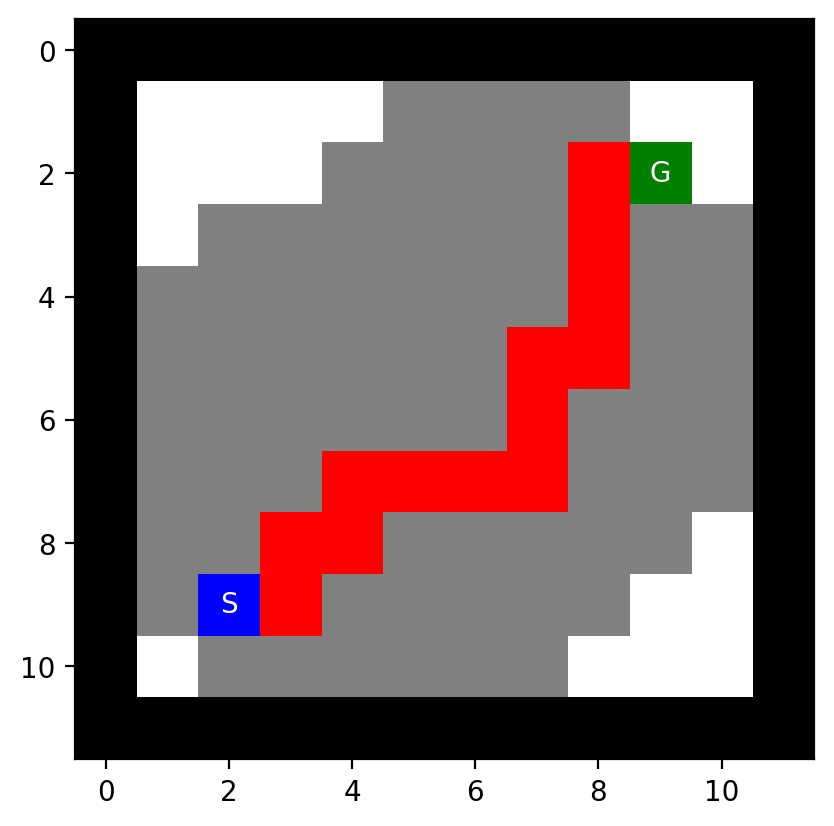

Maze: empty2
Path Cost: 14
Squares Explored: 75
Frontier Maximum: 31
Depth Maximum: 14


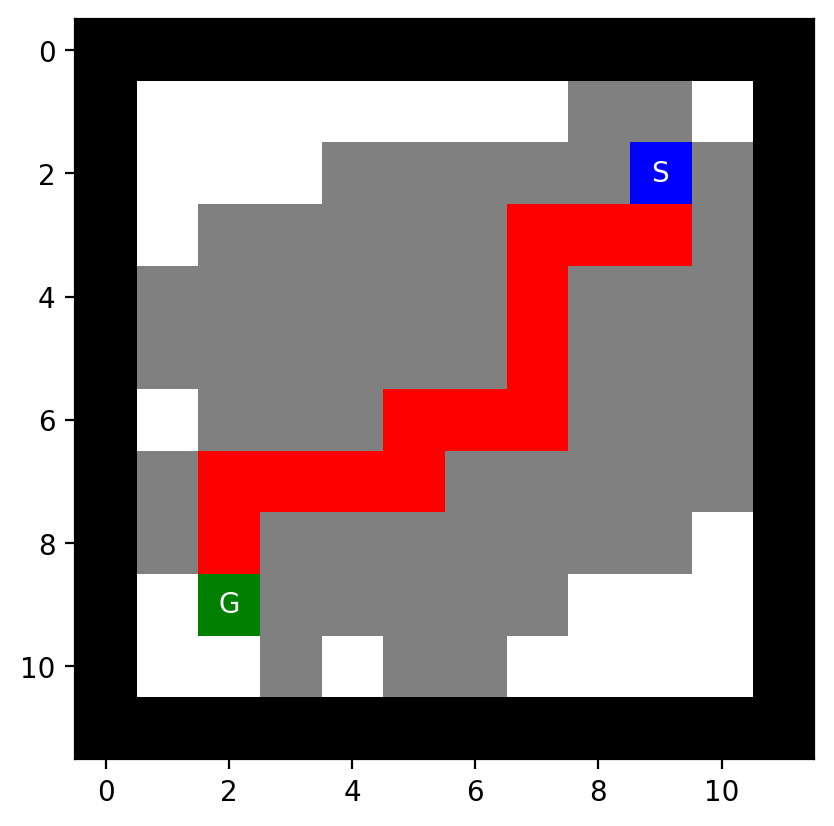

Maze: wall
Path Cost: 14
Squares Explored: 73
Frontier Maximum: 31
Depth Maximum: 14


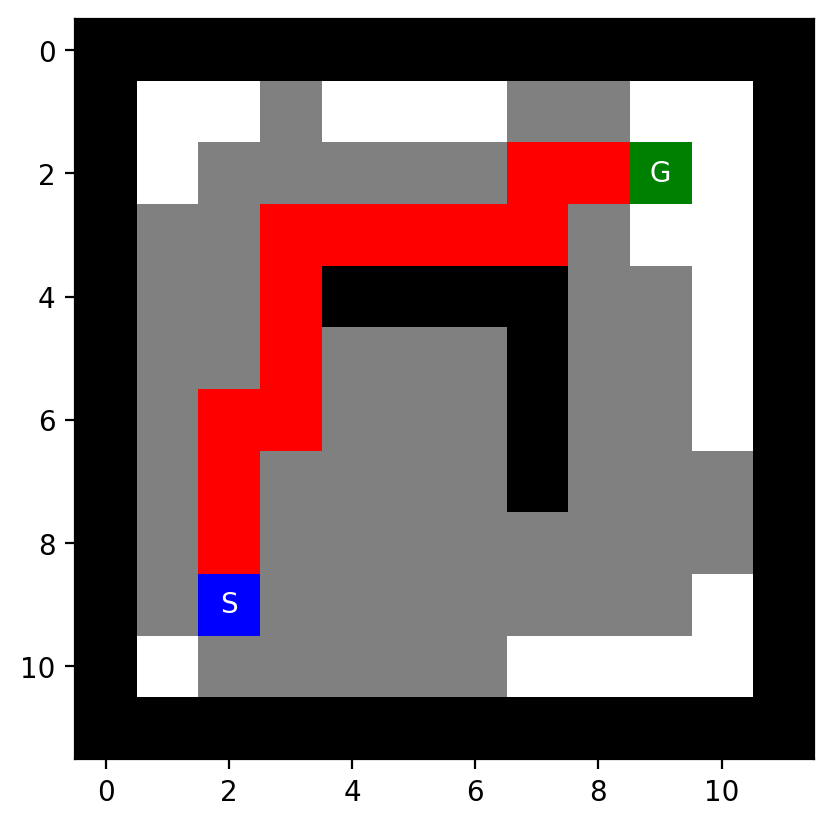

Maze: loops
Path Cost: 23
Squares Explored: 61
Frontier Maximum: 9
Depth Maximum: 23


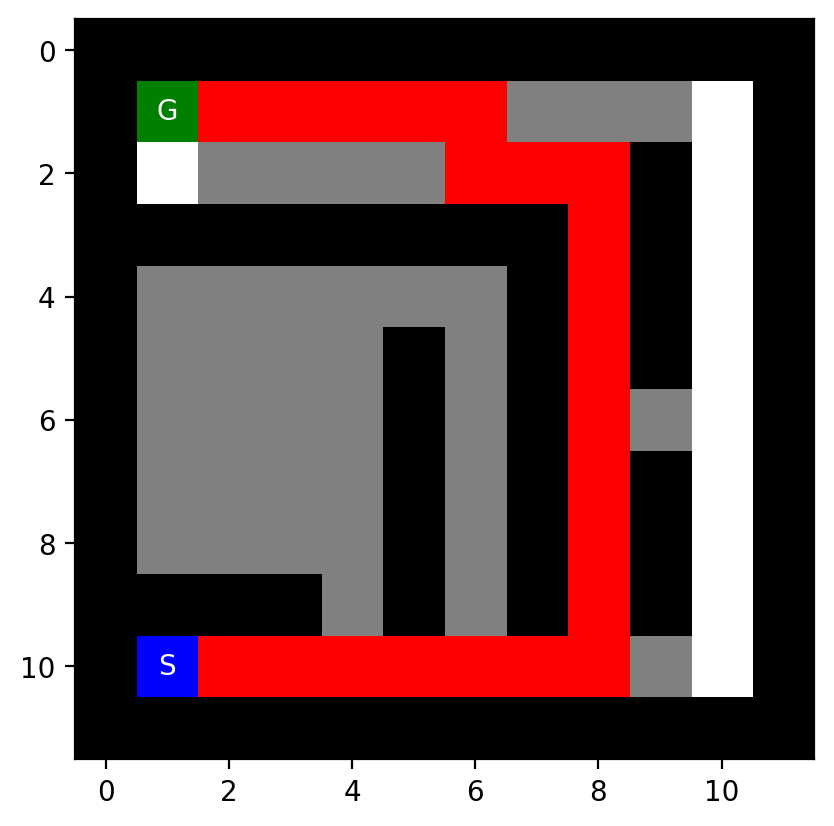

In [536]:
# Add code
search_methods = ["BFS", "DFS"]
test_maze2(search_methods)

search_methods = ["GBFS", "A*"]
test_maze3(search_methods)

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

In [537]:
# Add charts
import pandas as pd
import matplotlib.pyplot as plt

df_init = pd.DataFrame({'algorithm': [],'path cost': [],'# of nodes expanded': [],'max tree depth': [],'max # of nodes in memory': [], 'max frontier size': []})

methods = ["BFS", "DFS", "GBFS", "A*"]

for search_maze in mazes.keys():
    df = df_init
    for method in methods:
        maze = load_maze(search_maze)
        results = []
        if(method == "BFS" or method == "DFS"):
            results = task2_search(maze, search_method = method)
        elif(method == "GBFS" or method == "A*"):
            results = task3_search(maze, search_method = method)

        df = df._append({
            'algorithm': method,
            'path cost': (len(results["path"])-1),
            '# of nodes expanded': (len(results["reached"])),
            'max tree depth': results["depth-maximum"],
            'max # of nodes in memory': "N/A*",
            'max frontier size': results["frontier-maximum"]
        }, ignore_index=True)
    print("Maze in Progress: {}".format(search_maze))
    display(df)

Maze in Progress: small


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,19.0,94.0,20.0,N/A*,9.0
1,DFS,37.0,44.0,37.0,N/A*,7.0
2,GBFS,29.0,44.0,29.0,N/A*,5.0
3,A*,19.0,59.0,19.0,N/A*,8.0


Maze in Progress: medium


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,68.0,272.0,69.0,N/A*,9.0
1,DFS,150.0,175.0,150.0,N/A*,9.0
2,GBFS,74.0,82.0,74.0,N/A*,4.0
3,A*,68.0,228.0,68.0,N/A*,8.0


Maze in Progress: large


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,210.0,625.0,211.0,N/A*,8.0
1,DFS,210.0,454.0,210.0,N/A*,32.0
2,GBFS,210.0,488.0,210.0,N/A*,25.0
3,A*,210.0,557.0,210.0,N/A*,14.0


Maze in Progress: open


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,54.0,684.0,54.0,N/A*,25.0
1,DFS,208.0,470.0,219.0,N/A*,210.0
2,GBFS,68.0,161.0,68.0,N/A*,80.0
3,A*,54.0,336.0,54.0,N/A*,78.0


Maze in Progress: empty


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,14.0,98.0,15.0,N/A*,12.0
1,DFS,24.0,52.0,24.0,N/A*,28.0
2,GBFS,14.0,37.0,14.0,N/A*,23.0
3,A*,14.0,77.0,14.0,N/A*,32.0


Maze in Progress: empty2


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,14.0,98.0,15.0,N/A*,12.0
1,DFS,18.0,43.0,18.0,N/A*,21.0
2,GBFS,14.0,39.0,14.0,N/A*,25.0
3,A*,14.0,91.0,14.0,N/A*,35.0


Maze in Progress: wall


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,14.0,91.0,15.0,N/A*,10.0
1,DFS,24.0,88.0,38.0,N/A*,37.0
2,GBFS,18.0,48.0,18.0,N/A*,27.0
3,A*,14.0,76.0,14.0,N/A*,33.0


Maze in Progress: loops


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
0,BFS,23.0,72.0,23.0,N/A*,8.0
1,DFS,45.0,66.0,45.0,N/A*,19.0
2,GBFS,23.0,60.0,23.0,N/A*,10.0
3,A*,23.0,61.0,23.0,N/A*,9.0


In the table above, I was running into issues keeping track of the "max # of nodes in memory" without messing up some of the other code that was need to perform the searches properly. Keeping track of what gets put in memory and what leaves memory, on top of finding a way to output that information caused some issues in the implementation of the search algorithms so I ended up omitting it from the charts above. 

Discuss the most important lessons you have learned from implementing the different search strategies. 

# Add discussion
Some of the most important things I have learned from implementing different search strategies are the effect a heuristic function can have on search efficiency and the search method used given the scenario. Though in this lab there were not any questions where euclidean distance was used as a heuristic function, doing research on implementing a heuristic function for the project helped me realize how creating a strong heuristic function can be extremely beneficial for overcoming search problems. Strong heuristic functions can improve both time and space complexity drastically as I noted for GBFS. Each search method has its pros and cons, for example, DFS is great for searching a goal state in a finite open space where the goal state is further away whereas BFS is great for finding a goal state that can be hidden but a little closer. As I continue to learn more about real world applications in this course, I can see how important little changes like heuristic functions and choosing search methods can be in solving a problem in a timely manner. 

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

1. Implement IDS (iterative deepening search using DFS) and test it on the mazes above. You may run into some issues with open mazes. Please report and discuss these issues.

2. Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.


Strategy: IDS

Maze: small
Path Cost: 19
Squares Explored: 92
Frontier Maximum: 6
Depth Maximum: 19


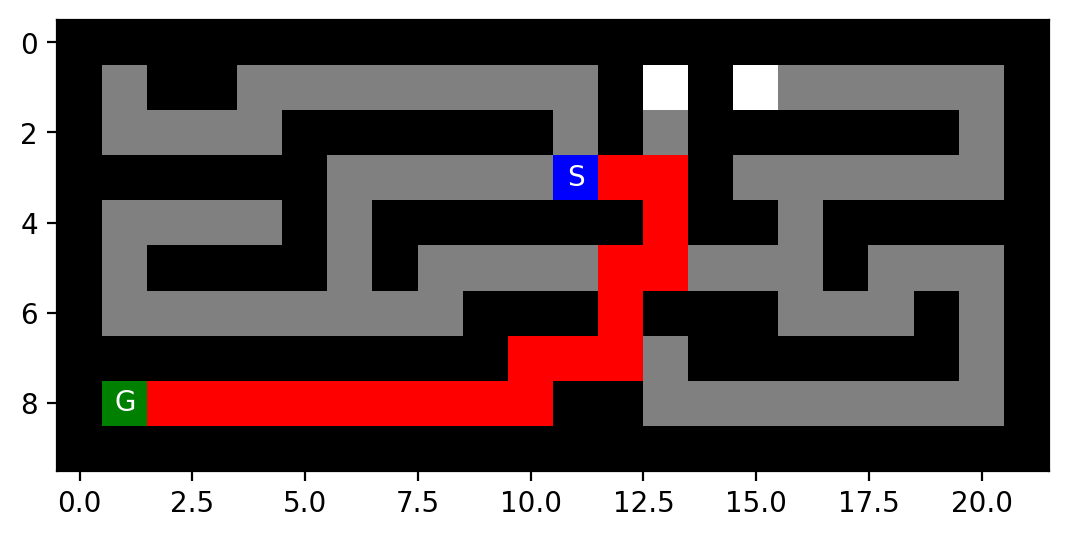

Maze: medium
Path Cost: 68
Squares Explored: 256
Frontier Maximum: 8
Depth Maximum: 68


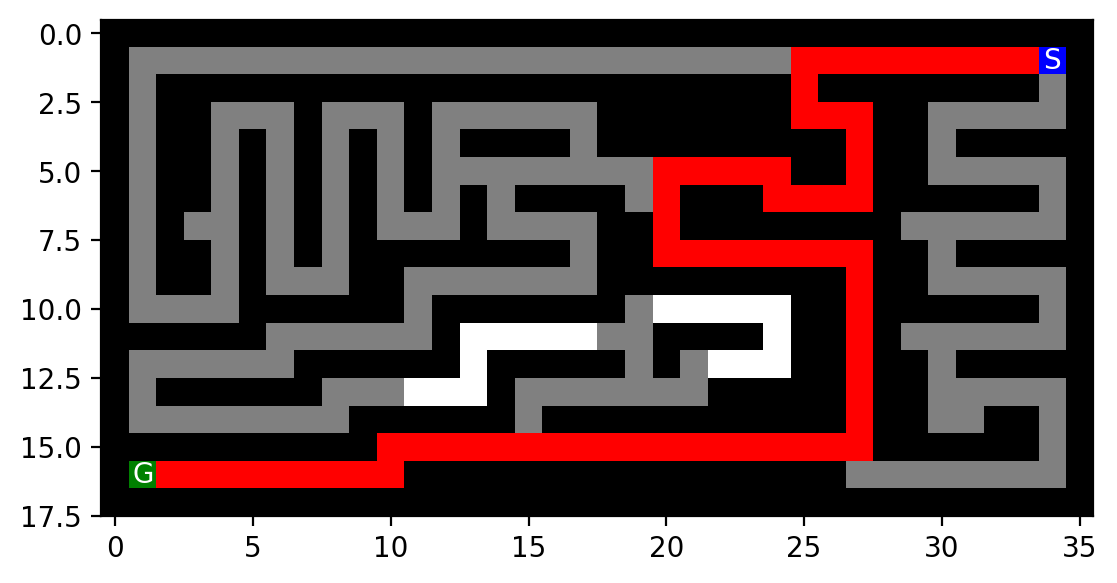

Maze: large
Path Cost: 210
Squares Explored: 475
Frontier Maximum: 40
Depth Maximum: 210


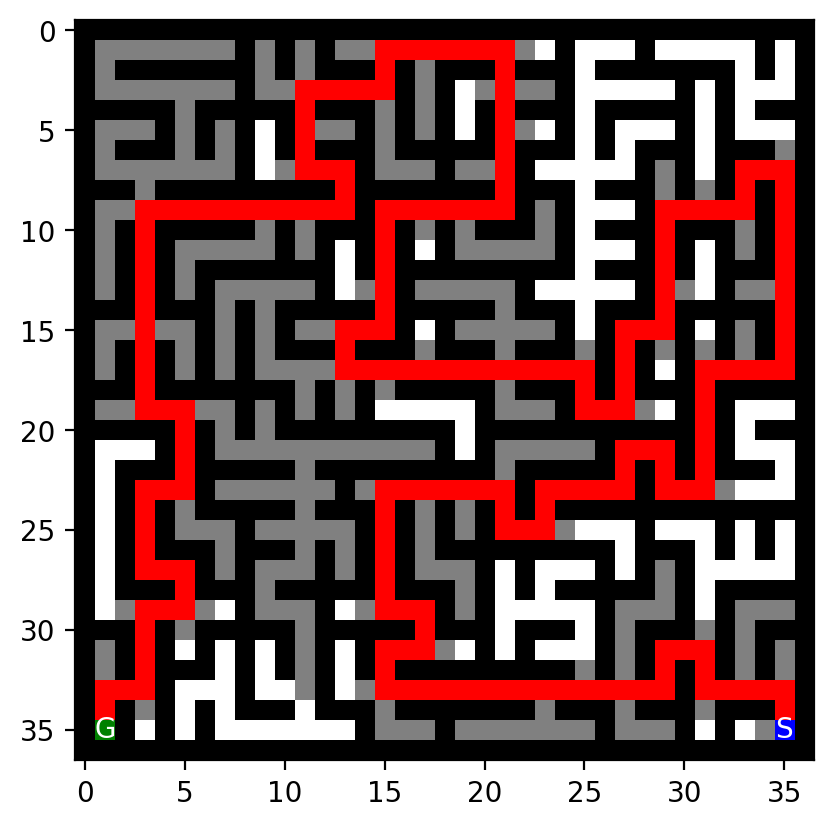

Maze: open
Path Cost: 54
Squares Explored: 677
Frontier Maximum: 64
Depth Maximum: 54


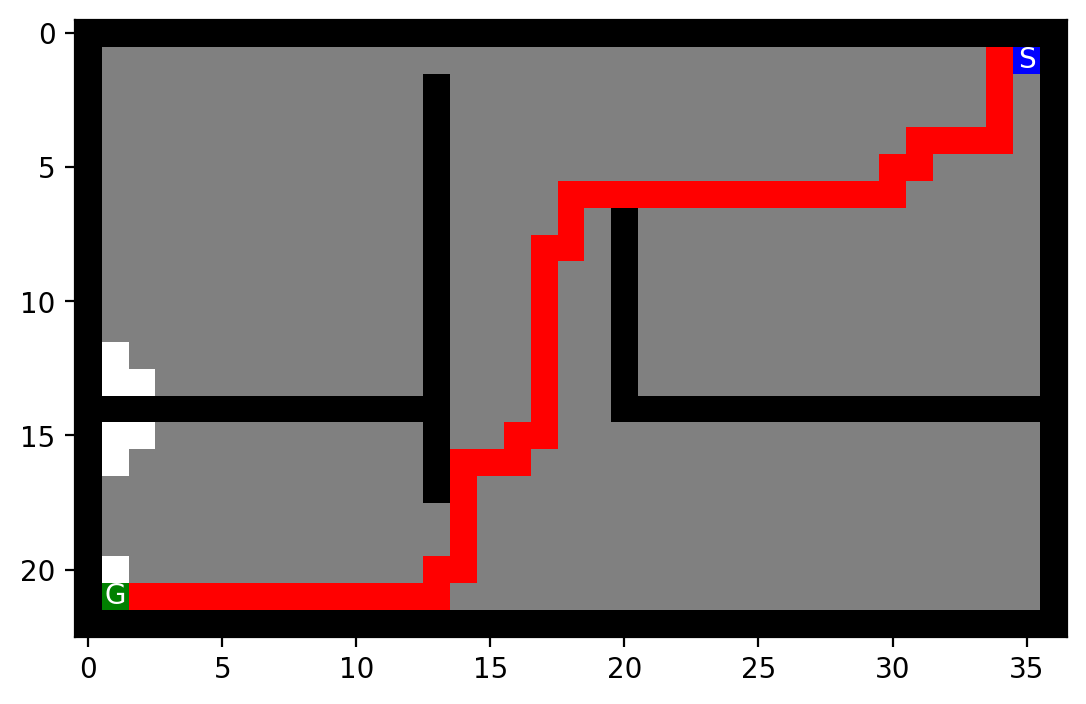

Maze: empty
Path Cost: 14
Squares Explored: 94
Frontier Maximum: 17
Depth Maximum: 14


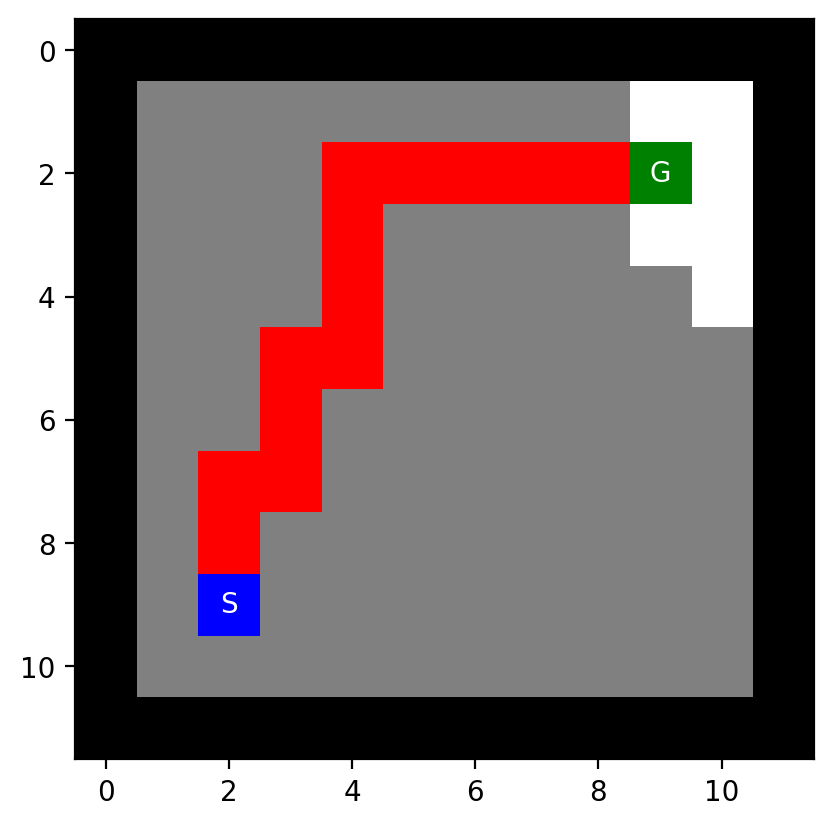

Maze: empty2
Path Cost: 14
Squares Explored: 87
Frontier Maximum: 21
Depth Maximum: 14


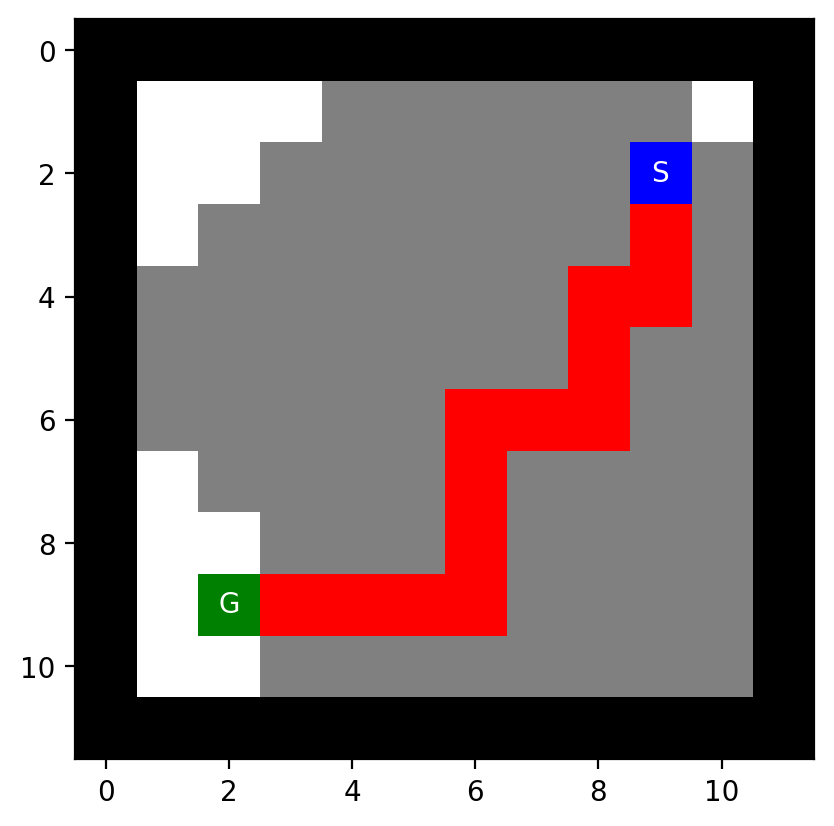

Maze: wall
Path Cost: 14
Squares Explored: 70
Frontier Maximum: 18
Depth Maximum: 14


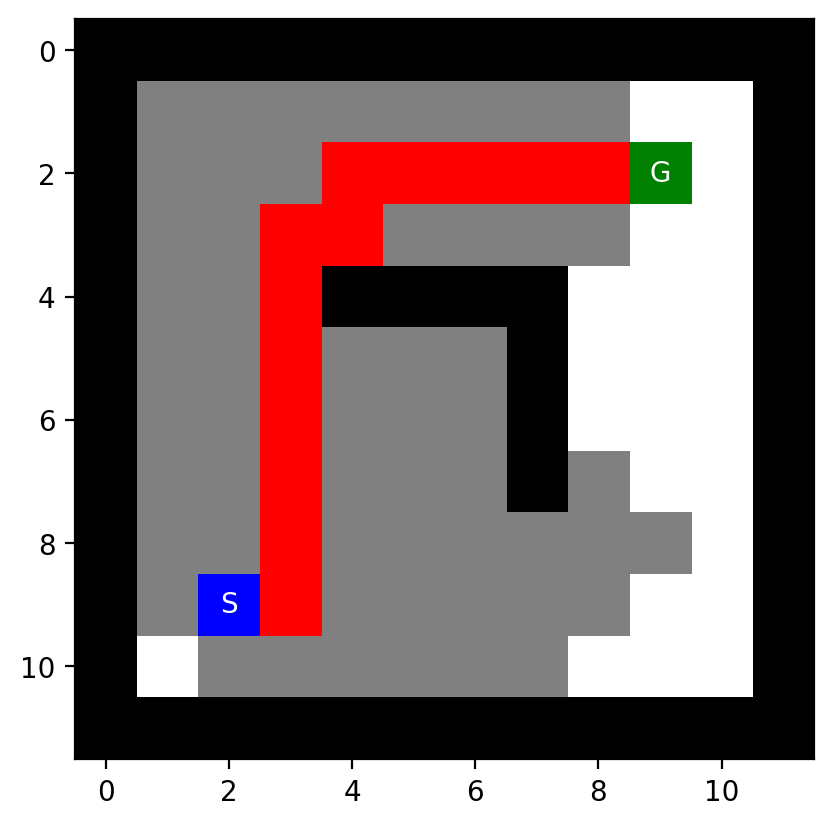

Maze: loops
Path Cost: 23
Squares Explored: 71
Frontier Maximum: 12
Depth Maximum: 23


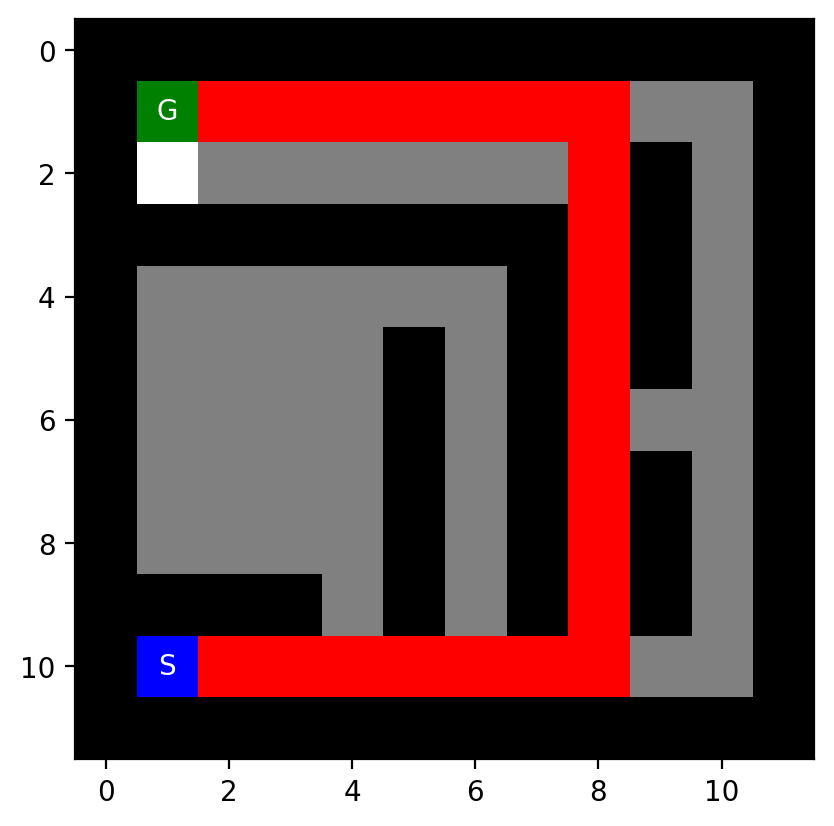

In [538]:
# Your code/answer goes here
def advanced_task_search(maze, search_method = "IDS"):

    #Find the initial state position and the goal state position
    start_pos = mh.find_pos(maze, "S")
    end_pos = mh.find_pos(maze, "G")
        
    #Initial state position becomes root node
    root = Node(pos=start_pos, parent=None, action=None, cost=0)

    #Creating the frontier for the search
    frontier = []
    frontier.append(root)

    #Creating list of nodes that have been visited
    reached = dict()
    reached[tuple(root.pos)] = root

    #Keeping track of the maximum frontier and depth
    frontier_maximum = 0
    depth_maximum = 0

    #IDS parameter
    depth_limit = 0
    
    #Set the current node as the root node
    node = root
    
    #Keep searching until the goal state is reached or if nothing remains in the frontier
    while not (len(frontier) < 1):

        #Continue to update frontier maximum if necessary
        if(len(frontier) > frontier_maximum):
            frontier_maximum = len(frontier)

        #Using search method to move forward on the frontier
        if(search_method == "IDS"):
            node = frontier.pop(-1)

        else:
            print("Strategy does not exit.")
            return(None)
        
        #Check to see if the goal state has been reached
        if(mh.look(maze, node.pos) == "G"):
            return({
                "path": node.get_path_from_root(),
                "reached": reached.keys(),
                "frontier-maximum": frontier_maximum,
                "depth-maximum": depth_maximum
            })
        
        #Continue expanding from current node if not at goal state
        else:
            #Reset root and increase the IDS limit depth by 1 if the limit was reached and the frontier is empty,
            #if not, keep expanding along the frontier
            if(search_method == "IDS"):
                if((g(node) == depth_limit)):
                    if(len(frontier) == 0):
                        root = Node(pos=start_pos, parent=None, action=None, cost=0)
                        frontier = [root]
                        reached = dict()
                        reached[tuple(root.pos)] = root
                        depth_limit = depth_limit + 1
                    continue

            #Check what actions can be performed
            for position in possible_positions(maze, node.pos):
                #If an available and ideal action takes you to a visited node, do not add to frontier to prevent looping in search
                if(search_method in ["IDS"]):
                    if(tuple(position) in reached.keys()):
                        if(g(reached[tuple(position)]) <= g(node) + 1):
                            continue

                elif(tuple(position) in reached.keys()):
                    continue

                #If the successive position is not yet on the frontier or is a better node for the frontier, add it to frontier
                n = Node(pos=position, parent=node, action=None, cost=1)

                if(g(n) > depth_maximum):
                    depth_maximum = g(n)

                frontier.append(n)
                reached[tuple(position)] = n

            #Check for looping by referring to the visited nodes dictionary
            if(search_method == "IDS" and len(frontier) == 0):
                root = Node(pos=start_pos, parent=None, action=None, cost=0)
                frontier = [root]
                reached = dict()
                reached[tuple(root.pos)] = root
                depth_limit = depth_limit + 1
                
    return(None)



def advanced_test_maze(methods):
    print()
    for method in methods:
        print(f"Strategy: {method}")
        print()
        for search_maze in mazes.keys():
            maze = load_maze(search_maze)
            results = advanced_task_search(maze, search_method=method)
            print("Maze: {}".format(search_maze))
            print("Path Cost: {}".format(len(results["path"])-1))
            print("Squares Explored: {}".format(len(results["reached"])))
            print("Frontier Maximum: {}".format(results["frontier-maximum"]))
            print("Depth Maximum: {}".format(results["depth-maximum"]))
            show_path(maze, results["path"], results["reached"])
        print()


search_methods = ["IDS"]
advanced_test_maze(search_methods)


Strategy: BFS

Maze: small2
Path Cost: 10
Squares Explored: 55
Frontier Maximum: 9
Depth Maximum: 11


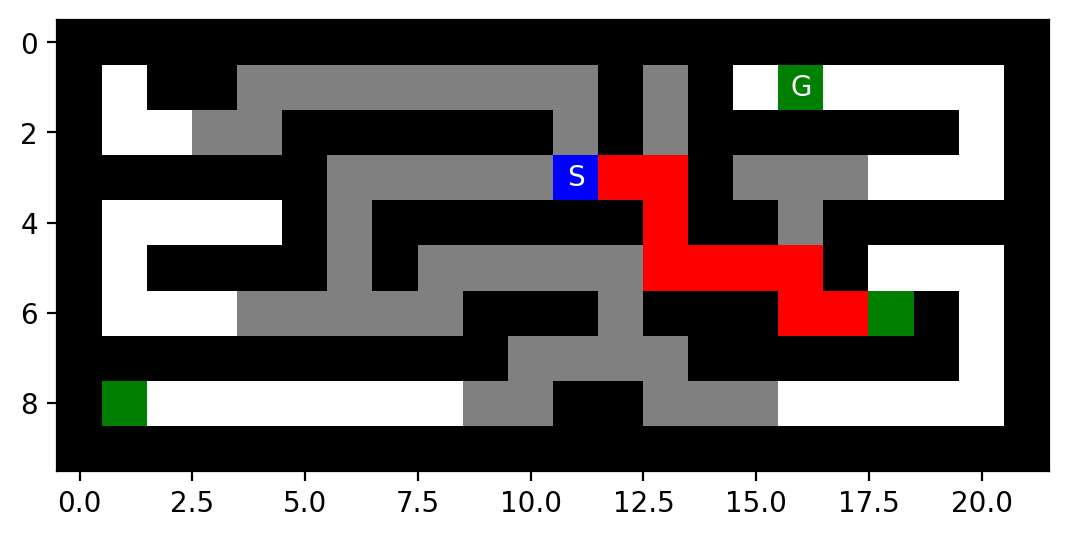

Maze: medium2
Path Cost: 23
Squares Explored: 62
Frontier Maximum: 4
Depth Maximum: 23


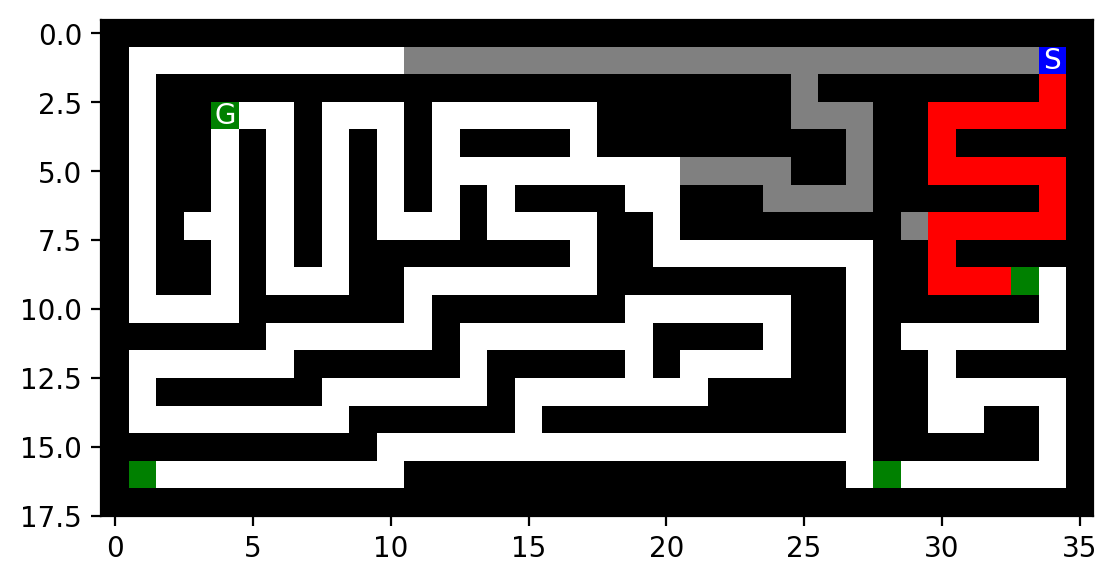

Maze: large2
Path Cost: 90
Squares Explored: 218
Frontier Maximum: 6
Depth Maximum: 90


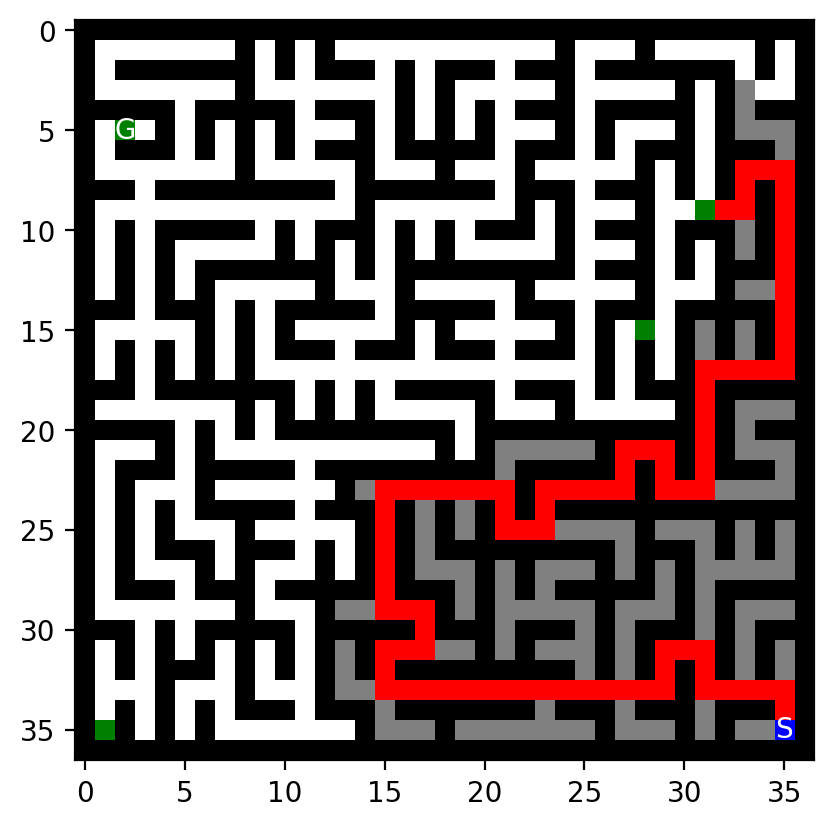


Strategy: DFS

Maze: small2
Path Cost: 19
Squares Explored: 26
Frontier Maximum: 7
Depth Maximum: 19


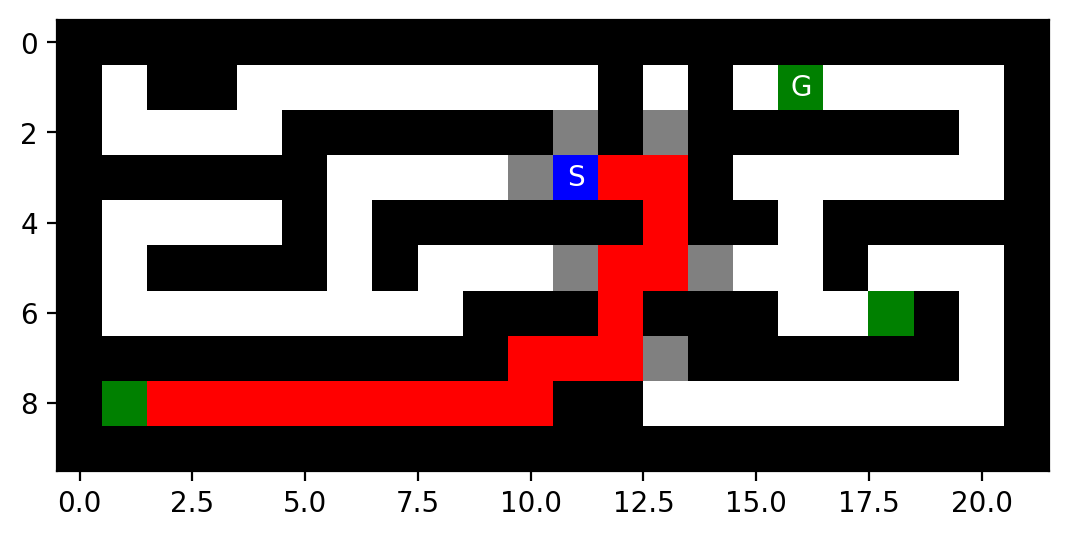

Maze: medium2
Path Cost: 43
Squares Explored: 49
Frontier Maximum: 5
Depth Maximum: 43


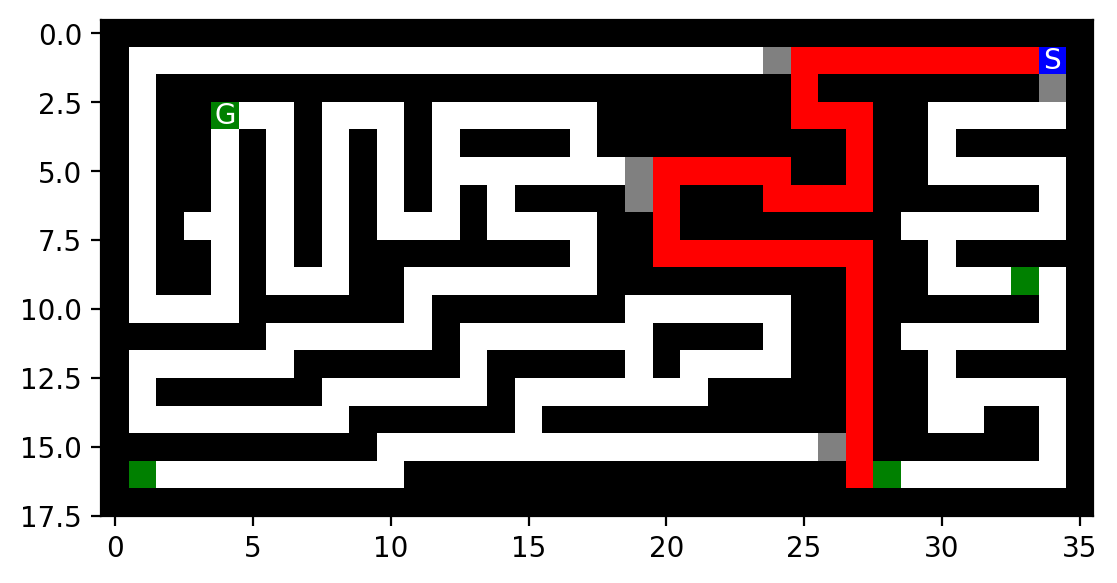

Maze: large2
Path Cost: 90
Squares Explored: 192
Frontier Maximum: 10
Depth Maximum: 96


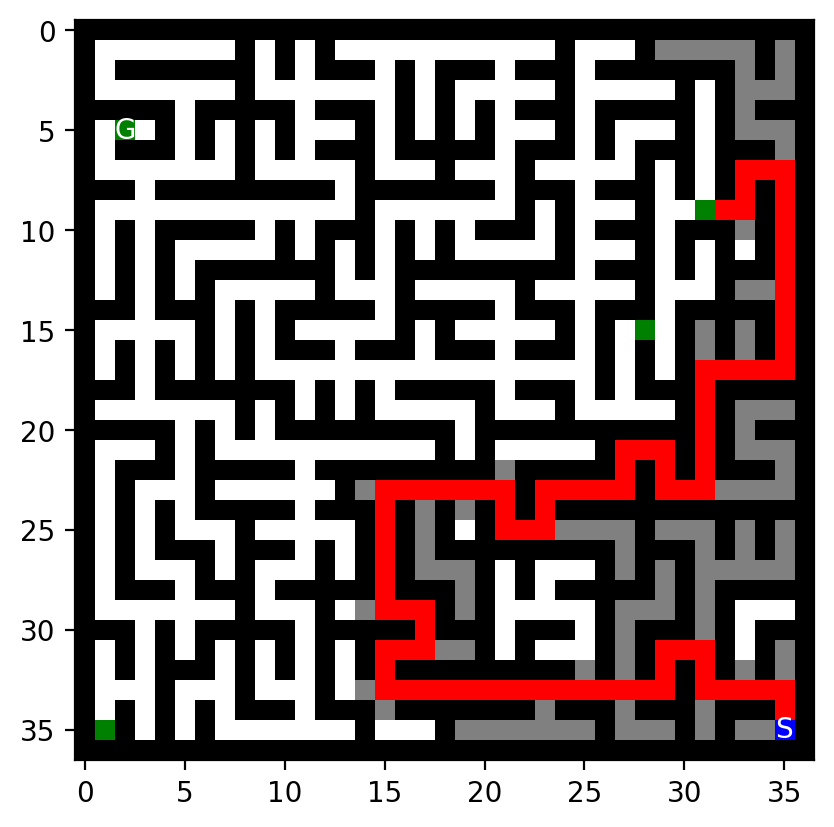



Strategy: IDS

Maze: small2
Path Cost: 10
Squares Explored: 37
Frontier Maximum: 5
Depth Maximum: 10


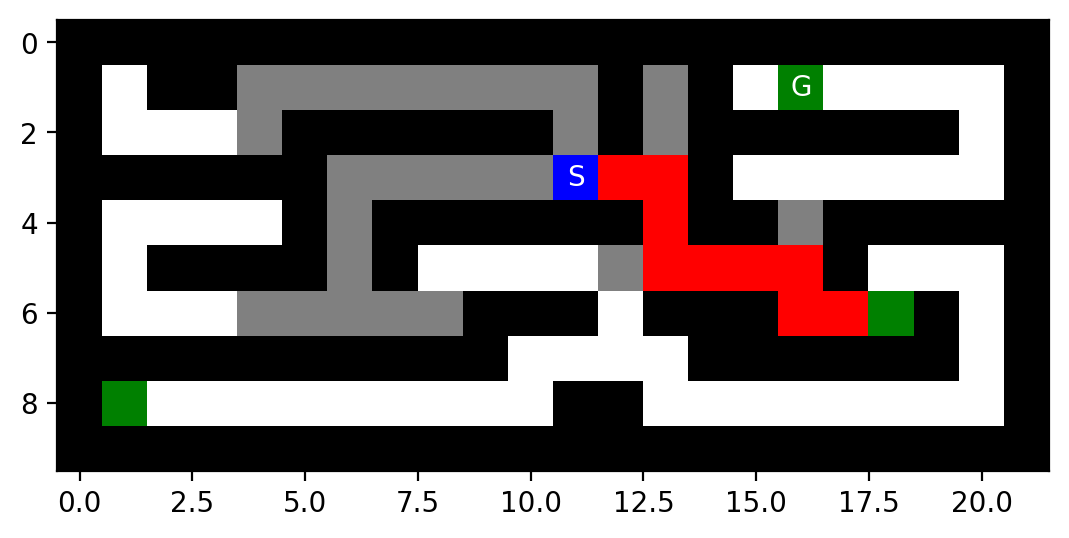

Maze: medium2
Path Cost: 23
Squares Explored: 26
Frontier Maximum: 3
Depth Maximum: 23


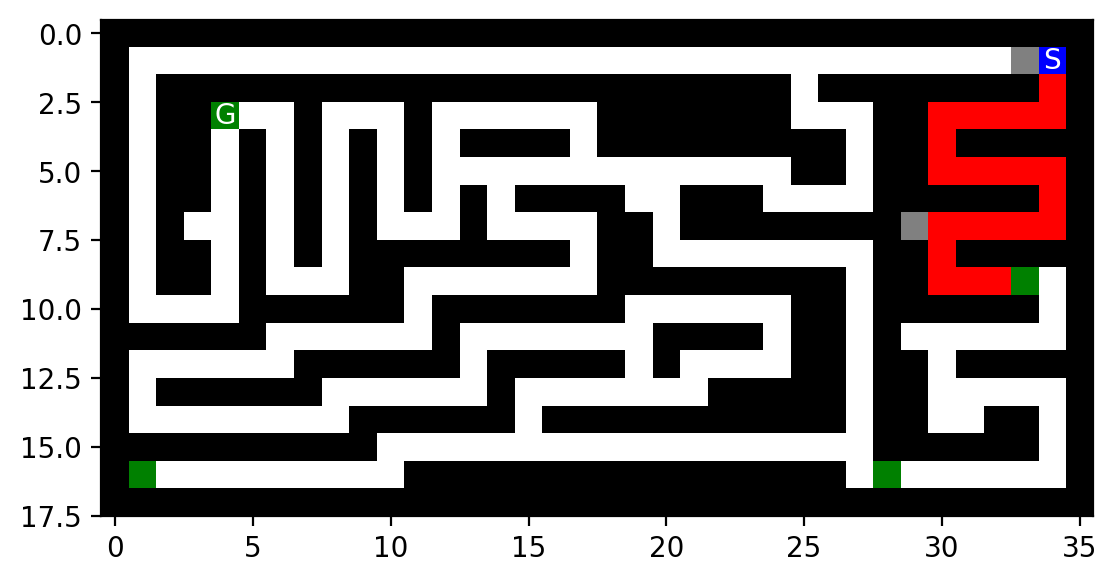

Maze: large2
Path Cost: 90
Squares Explored: 172
Frontier Maximum: 16
Depth Maximum: 90


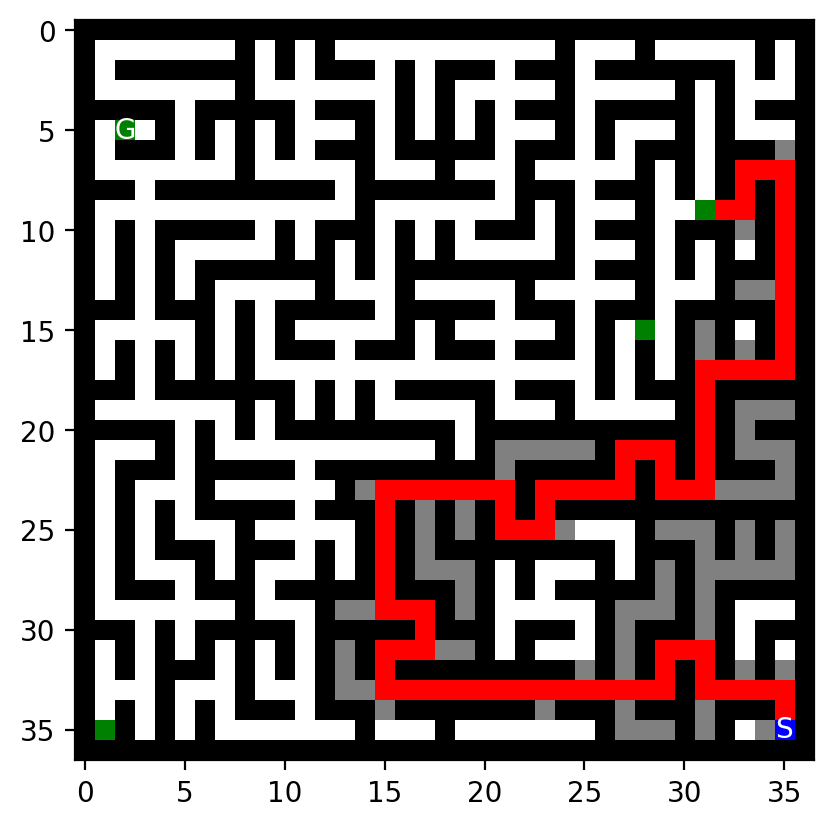

In [539]:
def extra_test_maze2(methods):
    print()
    for method in methods:
        print(f"Strategy: {method}")
        print()
        for search_maze in advanced_mazes.keys():
            maze = load_advanced_maze(search_maze)
            results = task2_search(maze, search_method=method)
            print("Maze: {}".format(search_maze))
            print("Path Cost: {}".format(len(results["path"])-1))
            print("Squares Explored: {}".format(len(results["reached"])))
            print("Frontier Maximum: {}".format(results["frontier-maximum"]))
            print("Depth Maximum: {}".format(results["depth-maximum"]))
            show_path(maze, results["path"], results["reached"])
        print()


search_methods = ["BFS", "DFS"]
extra_test_maze2(search_methods)



def extra_advanced_test_maze(methods):
    print()
    for method in methods:
        print(f"Strategy: {method}")
        print()
        for search_maze in advanced_mazes.keys():
            maze = load_advanced_maze(search_maze)
            results = advanced_task_search(maze, search_method=method)
            print("Maze: {}".format(search_maze))
            print("Path Cost: {}".format(len(results["path"])-1))
            print("Squares Explored: {}".format(len(results["reached"])))
            print("Frontier Maximum: {}".format(results["frontier-maximum"]))
            print("Depth Maximum: {}".format(results["depth-maximum"]))
            show_path(maze, results["path"], results["reached"])
        print()


search_methods = ["IDS"]
extra_advanced_test_maze(search_methods)

# Observations from multiple goals maze test
Both IDS and BFS were much better in finding the closest goal in the maze unlike DFS. This is due to the nature of the DFS search and how it continues to dive as deep as it can go down a tree until it cannot go any further. You can see this specifically with mazes small2 and medium2 where DFS went to the third or fourth furthest goal from the starting position. These results are also a result of probability because depending on the path DFS initially chooses, at times it can pick the optimal path right away whereas other times it will pick the worst path possible. This would be something worth exploring more into, whether it be checking how a search method can reach multiple goal states in one path or how quickly it can reach each goal state from the initial state.

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [540]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [541]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [542]:
# Your code/answer goes here